## Context

## Objective

- Explore and visualize the dataset.
- Build clean the data set and missing values.
- Generate a set of insights from the dataset.

### The key question

Do natural disasters worsen the gender-based nutritional disparity among children in Bangladesh?

### Problem Formulation:

We have a regression problem at hand where we will try to run a diff in diff to see if we can find evidence for a gender bais as.

### Proposed approach

Since it is a regression problem we will first start with the parametric model linear regression with a diff-in-diff approache.

### Overall solution design :

The potential solution design would look like this:

- Checking the data description to get the idea of basic statistics or summary of data.
- Univariate analysis to see how data is spread out, getting to know about the outliers.
- Bivariate analysis to see how different attributes vary with the dependent variable.
- Outlier treatment if needed.
- Missing value treatment using appropriate techniques.
- Feature engineering - transforming features, creating new features if possible.
- Choosing the model evaluation technique - 1) R Squared 2) RMSE can be any other metrics related to regression analysis.
- Splitting the data and proceeding with modeling.


### Measures of success :

R-squared.

## Data Dictionary

## Importing the necessary libraries and overview of the dataset

In [269]:
# removing all unnecessary objects
#for curr_object in dir():
#    del globals()[curr_object]

#locals().clear()

In [270]:
# Importing the basic libraries we will require for the project

# Import libraries for data manipulation
import pandas as pd
import numpy as np
import os
# Import libraries for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization            
import seaborn as sns      

# Import necessary modules
import geopandas as gpd
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

# import module for geoencoding
from geopy.geocoders import Nominatim

# to generate random number
from random import randint

# add sleep time
from time import sleep

import logging

# Set up the color sheme:
import mapclassify as mc

# to compute zscores: https://pypi.org/project/cgmzscore/
# Resource R: https://rdrr.io/github/WorldHealthOrganization/anthroplus/man/anthroplus_zscores.html
#from cgmzscore.src.main import z_score_lhfa
#from cgmzscore.src.main import z_score_wfa
#import ast
#https://github.com/ewheeler/pygrowup
from pygrowup import Observation
from decimal import Decimal

import datetime

## Functions

In [271]:
# def return_non_na(curr_data,col):
#     return curr_data[col].replace(['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO','Missing'], np.NaN, inplace=True)



def reverse_geocode(geolocator, latlon, sleep_sec):
    """
    This function attempts to perform reverse geocoding using the provided geolocator
    and latitude-longitude coordinates. It handles potential errors and retries on timeouts.

    Args:
        geolocator (object): A geocoding library object used for reverse geocoding.
        latlon (str): A string in the format "latitude,longitude" representing the location.
        sleep_sec (int): The maximum number of seconds to sleep between retries on timeouts.

    Returns:
        object: The result of the reverse geocoding request (may vary depending on the geocoder library).
                - On success, returns the geocoded information.
                - On timeout, retries up to sleep_sec seconds and returns the result.
                - On service error or other exceptions, returns None.
    """

    try:
        # Attempt reverse geocoding using the geolocator in English language
        return geolocator.reverse(latlon, language='en')
    except GeocoderTimedOut:
        # Handle timeout error
        logging.info('TIMED OUT: GeocoderTimedOut: Retrying...')
        # Introduce a random sleep between 1 and sleep_sec seconds to avoid overwhelming the service
        sleep(randint(1 * 100, sleep_sec * 100) / 100)
        # Retry the reverse geocoding with the same parameters
        return reverse_geocode(geolocator, latlon, sleep_sec)
    except GeocoderServiceError as e:
        # Handle service error (e.g., connection refused)
        logging.info('CONNECTION REFUSED: GeocoderServiceError encountered.')
        logging.error(e)  # Log the detailed error for debugging
        return None  # Indicate failure
    except Exception as e:
        # Handle unexpected exceptions
        logging.info('ERROR: Terminating due to exception {}'.format(e))
        return None  # Indicate failure
    

def get_local_information(curr_data, sleep_sec):
    """
    This function enriches a DataFrame with local address information based on latitude and longitude data.

    Args:
        curr_data (pandas.DataFrame): A DataFrame with columns 'LATNUM' and 'LONGNUM' containing latitude and longitude values.
        sleep_sec (int): Number of seconds to sleep between retries for error handling.

    Returns:
        pandas.DataFrame: The DataFrame with additional columns for city, village, county, state_district, state, and country.
        """

    # Initialize the Nominatim geocoder with a user agent string (important for API usage guidelines)
    user_agent = 'bibouPaultest_{}'.format(randint(10000, 99999)) + '@gmail.com'
    geolocator = Nominatim(user_agent=user_agent)

    # Iterate through each row of the DataFrame
    for curr_line in range(curr_data.index.max() + 1):

        # Extract latitude and longitude values for the current row
        Latitude = str(curr_data.loc[curr_line, "LATNUM"])
        Longitude = str(curr_data.loc[curr_line, "LONGNUM"])

        # Perform reverse geocoding to get address information
        location = reverse_geocode(geolocator, Latitude + "," + Longitude, sleep_sec)  # Uses a custom function for retries

        # Extract relevant address components from the geocoding result
        if location:
            address = location.raw['address']
            city = address.get('city')
            village = address.get('village')
            county = address.get('county')
            state_district = address.get('state_district')
            state = address.get('state')
            country = address.get('country')

        # Update the DataFrame with the extracted address information
            curr_data.loc[curr_line, 'city'] = city
            curr_data.loc[curr_line, 'village'] = village
            curr_data.loc[curr_line, 'county'] = county
            curr_data.loc[curr_line, 'state_district'] = state_district
            curr_data.loc[curr_line, 'state'] = state
            curr_data.loc[curr_line, 'country'] = country

        else:
            # Update the DataFrame with the extracted address information
            curr_data.loc[curr_line, 'city'] = np.NAN
            curr_data.loc[curr_line, 'village'] = np.NAN
            curr_data.loc[curr_line, 'county'] = np.NAN
            curr_data.loc[curr_line, 'state_district'] = np.NAN
            curr_data.loc[curr_line, 'state'] = np.NAN
            curr_data.loc[curr_line, 'country'] = np.NAN
    
    # Return the DataFrame with the added address information
    return curr_data


def correct_id(curr_row, nbr_max):
    """
    This function ensures that the input string `curr_row` is formatted to a specified length `nbr_max` 
    by adding leading zeros if necessary.

    Parameters:
    curr_row (str): The current row ID that needs to be corrected.
    nbr_max (int): The maximum length that the corrected ID should have.
    """
    # Check if the length of the current row ID is less than the maximum allowed length
    if len(curr_row) < nbr_max:
        # Calculate the number of leading zeros needed to reach the maximum length
        nbr_resid = nbr_max - len(curr_row) 
        # Add the leading zeros to the beginning of the current row ID and return as a string
        if curr_row.count('.') == 0:
            return str(nbr_resid * '0' + curr_row)
        else:
            # Add extra leading zeros if the current row ID contains a period (.)
            return str((nbr_resid + 2) * '0' + curr_row)
    # Check if the length of the current row ID is exactly equal to the maximum allowed length
    elif len(curr_row) == nbr_max:
        # Return the current row ID as a string, adding two leading zeros if it contains a period
        if curr_row.count('.') == 0:
            return str(curr_row)
        else:
            return str(2 * '0' + curr_row)
    # Case where the length of the current row ID is greater than the maximum allowed length
    else: 
        # Check if the period is in the third position
        if curr_row.find('.') == 2: 
            return str('00' + curr_row)
        # Check if the period is in the fourth position
        elif curr_row.find('.') == 3: 
            return str('0' + curr_row)
        # Return the current row ID as is
        else: 
            return str(curr_row)
        
def formatNumber(num):
    # Check if the number is an integer (i.e., no fractional part)
    if num % 1 == 0:
        # If it is an integer, convert it to an integer type and return it
        return int(num)
    else:
        # If it is not an integer, return the number as it is
        return num
    
def vertical_mean_line_survived(x, **kwargs):
    """
    This function draws a vertical line on a plot at the mean value of the input data 'x'.
    The style and color of the line are determined by additional keyword arguments.

    Parameters:
    x (array-like): The data for which the mean will be calculated.
    **kwargs: Additional keyword arguments to customize the line.
        'label' (str): A label that can be 'male' or 'female' to determine the line style.
        'color' (str): The color of the line, default is green ('g').

    Example usage:
    vertical_mean_line_survived(data, label='male', color='b')
    """

    # Define line styles for male and female
    ls = {"male": "-", "female": "-"}
    
    # Draw a vertical line at the mean of 'x'
    plt.axvline(x.mean(), 
                linestyle=ls[kwargs.get("label")],  # Set line style based on 'label' keyword argument
                color=kwargs.get("color", "g"))     # Set line color based on 'color' keyword argument, default is green

# Example of how the function might be called:
# vertical_mean_line_survived(data, label='male', color='blue')

## Loading the data

### Round 1 data

In [272]:
# Round 1 datasets

## HH identification data: Reading household identification data from a Stata file
df_r1 = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 1 (2011-2012)\\001_mod_a_male.dta') 
df_r1_f = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 1 (2011-2012)\\002_mod_a_female.dta') 

## FTF: Feed the Futur (FTF) census data from a Stata file
df_r1_ftf = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 1 (2011-2012)\\001_census_ftf.dta') 


### Sociaux economics characteristics
df_r1_SE = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 1 (2011-2012)\\003_mod_b1_male.dta') 

## Anthro data: Reading anthropometric data from Stata files
### 1 for all household members
df_r1_anthr1 = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 1 (2011-2012)\\045_mod_w1_female.dta') 

### 2 for under five children
df_r1_anthr2 = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 1 (2011-2012)\\046_mod_w2_female.dta') 

# Importing the Bangladesh raw map: Reading a shapefile containing administrative boundaries of Bangladesh
bgd_adm = gpd.read_file(os.getcwd() + '\\input\\shapefile_data\\shapefile_zip\\BGD_adm\\BGD_adm3.shp')


# Crosswalk to merge sociaux economic data to geographic informations
crosswalk = pd.read_excel(os.getcwd() + '\\input\\cross_walk_data_final.xlsx', dtype={'upazila_code':'category','code adm':'category','affected_upazila':'category'})


In [273]:

# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r1
df_r1 = df_r1.loc[:, ['div', 'dcode', 'uzcode', 'uncode','vcode_n', 'div_name', 'District', 
                    'District_Name', 'Upazila', 'Upazila_Name', 'Union', 'Union_Name','a01', 
                    'a02', 'a13', 'a15','a16_dd','a16_mm','a16_yy','Sample_type']]

## Rename specific columns for better readability and understanding
df_r1.rename(columns={'div':'division_code', 'District':'district_code', 'District_Name':'district_name','Upazila':'upazila_code','Upazila_Name':'upazila_name',  'Union':'union_code','Union_Name':'union_name','vcode_n':'village_code','a01': "hh_id",
                    "a02": "census_nbr", "a13": "hh_head_religion", "a15": "hh_ethnic_group",'a16_dd':'first_v_day','a16_mm':'first_v_month','a16_yy':'first_v_year', 'Sample_type':'sample_type'}, inplace=True)

## Convert specific columns to categorical data type for optimized performance and memory usage
### Identifiant
df_r1['division_code'] = df_r1['division_code'].astype("int64").astype("string")
df_r1['district_code'] = df_r1['district_code'].astype("int64").astype("string")
df_r1['upazila_code'] = df_r1['upazila_code'].astype("int64").astype("string")
df_r1['village_code'] = df_r1['village_code'].astype("int64").astype("string")
df_r1['hh_id'] = df_r1['hh_id'].astype("int64").astype("string")

df_r1['union_code'] = df_r1['union_code'].astype("int64").astype("string")
df_r1['census_nbr'] = df_r1['census_nbr'].astype("category")
df_r1['sample_type'] = df_r1['sample_type'].astype("category")



#df_r1 = df_r1.loc[(df_r1.sample_type!='FTF additional')]
#df_r1.sample_type.value_counts()

df_r1['first_v_day'] = df_r1['first_v_day'].astype("int64")
df_r1['first_v_month'] = df_r1['first_v_month'].astype("int64")
df_r1['first_v_year'] = df_r1['first_v_year'].astype("int64")

# Filtering to only consider household in the national representative sample
#df_r1 = df_r1.loc[(df_r1.sample_type=='FTF Original') | (df_r1.sample_type=='National Representative')]

# Creating the interview date
df_r1['date_int'] = pd.to_datetime(dict(year=df_r1.first_v_year, month=df_r1.first_v_month, day=df_r1.first_v_day))


# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r1.hh_id.str.len().max()
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r1["hh_id"] = df_r1.hh_id.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the upazila_code in the dataframe
nbr_max = df_r1.upazila_code.str.len().max()
## Apply the correct_id function to each upazila_code to ensure they all have the same length and update the 'upazila_code' column with the corrected IDs
df_r1["upazila_code"] = df_r1.upazila_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the village codes in the dataframe
nbr_max = df_r1.village_code.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r1["village_code"] = df_r1.village_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the union codes in the dataframe
nbr_max = df_r1.union_code.str.len().max()
## Apply the correct_id function to each union code to ensure they all have the same length and update the 'union_code' column with the corrected codes
df_r1["union_code"] = df_r1.union_code.apply(lambda row: correct_id(row, nbr_max))


# Build an unique IDs for each hh
df_r1["hh_id_cmplt"] = df_r1.apply(lambda row : str(row.loc["union_code"]) + str(row.loc["village_code"]) + str(row.loc["hh_id"]), axis=1)


In [274]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r1
df_r1_f = df_r1_f.loc[:, ['a01', 'div', 'dcode', 'uzcode', 'uncode','vcode_n', 'div_name', 'district', 
                    'district_name', 'upazila', 'upazila_name', 'union', 'union_name',
                    'a02', 'a13', 'a15','a16_dd','a16_mm','a16_yy','sample_type']]

## Rename specific columns for better readability and understanding
df_r1_f.rename(columns={'a01': "hh_id",'div':'division', "a02": "census_nbr", "a13": "hh_head_religion", "a15": "hh_ethnic_group", 'district':'district_code', 'district_name':'district_name',
                    'upazila':'upazila_code','vcode_n':'village_code', 'upazila_name':'upazila_name', 'union':'union_code', 'union_name':'union_name','a16_dd':'first_v_day','a16_mm':'first_v_month','a16_yy':'first_v_year', 'sample_type':'sample_type'}, inplace=True)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r1_f['hh_id'] = df_r1_f['hh_id'].astype("int64").astype("string")
df_r1_f['division'] = df_r1_f['division'].astype("int64").astype("string")
df_r1_f['village_code'] = df_r1_f['village_code'].astype("int64").astype("string")
df_r1_f['census_nbr'] = df_r1_f['census_nbr'].astype("category")
df_r1_f['sample_type'] = df_r1_f['sample_type'].astype("category")

df_r1_f['first_v_day'] = df_r1_f['first_v_day'].astype("int64")
df_r1_f['first_v_month'] = df_r1_f['first_v_month'].astype("int64")
df_r1_f['first_v_year'] = df_r1_f['first_v_year'].astype("int64")

# Filtering to only consider household in the national representative sample
#df_r1_f = df_r1_f.loc[(df_r1_f.sample_type=='ftf original') | (df_r1_f.sample_type=='national representative')]
# creating the interview date
#df_r1_f['date_int'] = pd.to_datetime(dict(year=df_r1_f.first_v_year, month=df_r1_f.first_v_month, day=df_r1_f.first_v_day))

# Correcting the id by adding '0' to obtain a unique Id.

## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r1_f.hh_id.str.len().max()
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r1_f["hh_id"] = df_r1_f.hh_id.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the upazila_code in the dataframe
nbr_max = df_r1_f.upazila_code.str.len().max()
## Apply the correct_id function to each upazila_code to ensure they all have the same length and update the 'upazila_code' column with the corrected IDs
df_r1_f["upazila_code"] = df_r1_f.upazila_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the village codes in the dataframe
nbr_max = df_r1_f.village_code.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r1_f["village_code"] = df_r1_f.village_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the union codes in the dataframe
nbr_max = df_r1_f.union_code.str.len().max()
## Apply the correct_id function to each union code to ensure they all have the same length and update the 'union' column with the corrected codes
df_r1_f["union_code"] = df_r1_f.union_code.apply(lambda row: correct_id(row, nbr_max))


# Build an unique IDs for each hh
df_r1_f["hh_id_cmplt"] = df_r1_f.apply(lambda row : str(row.loc["union_code"]) + str(row.loc["village_code"]) + str(row.loc["hh_id"]), axis=1)

In [275]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r1
df_r1_ftf = df_r1_ftf.loc[:, ['a01', 'division', 'dcode', 'uzcode', 'uncode', 'vcode', 'district', 'village','distri_a', 'upazila', 'upazil_a', 'union', 'union_na','a1_01', 'a1_02', 'a1_03',"a1_04","a1_05","a1_06"]]

## Rename specific columns for better readability and understanding
df_r1_ftf.rename(columns={'a01': "hh_id", 'vcode':'village_name', 'village':'village_code', 'division':'div_name', 'district':'district_code','distri_a':'district_name',
                    'upazila':'upazila_code', 'upazil_a':'upazila_name','union':'union_code', 'union_na':'union_name', "a1_01": "sexe_hhm", "a1_02": "age_hhm",
                    "a1_03":"relation_head_hh","a1_04":"marital_status_hhm","a1_05":"literacy_hhm","a1_06":"education_high"}, inplace=True)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r1_ftf['hh_id'] = df_r1_ftf['hh_id'].astype("int64", errors='ignore').astype("string")
df_r1_ftf['div_name'] = df_r1_ftf['div_name'].astype("string")
df_r1_ftf['village_code'] = df_r1_ftf['village_code'].astype("int64").astype("string")
df_r1_ftf['sexe_hhm'] = df_r1_ftf['sexe_hhm'].astype("category")
df_r1_ftf['age_hhm'] = df_r1_ftf['age_hhm'].astype("int64")
df_r1_ftf['relation_head_hh'] = df_r1_ftf['relation_head_hh'].astype("category")
df_r1_ftf['marital_status_hhm'] = df_r1_ftf['marital_status_hhm'].astype("category")
df_r1_ftf['literacy_hhm'] = df_r1_ftf['literacy_hhm'].astype("category")
df_r1_ftf['education_high'] = df_r1_ftf['education_high'].astype("category")


# Correcting the id by adding '0' to obtain a unique Id.

## Find the maximum length of the household IDs in the dataframe
#nbr_max = df_r1_ftf.hh_id.str.len().max()
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
###df_r1_ftf["hh_id"] = df_r1_ftf.hh_id.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the village codes in the dataframe
###nbr_max = df_r1_ftf.village_code.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
###df_r1_ftf["village_code"] = df_r1_ftf.village_code.apply(lambda row: correct_id(row, nbr_max))



In [276]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r1
df_r1_anthr1 = df_r1_anthr1.loc[:, ['a01', 'mid', 'w1_01', 'w1_02', 'w1_03','w1_04', 'w1_05', 'sample_type']]

## Rename specific columns for better readability and understanding
df_r1_anthr1.rename(columns={'a01': "hh_id",'mid':'hhm_id', "w1_01": "are_you_pregnant", "w1_02": "are_you_lactating", 
                            "w1_03": "weight_kg", 'w1_04':'height_cm', 'w1_05':'if_not_measured_why','sample_type':'sample_type'}, inplace=True)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r1_anthr1['hh_id'] = df_r1_anthr1['hh_id'].astype("int64").astype("string")
df_r1_anthr1['hhm_id'] = df_r1_anthr1['hhm_id'].astype("int64").astype("string")
df_r1_anthr1['are_you_pregnant'] = df_r1_anthr1['are_you_pregnant'].astype("category")
df_r1_anthr1['are_you_lactating'] = df_r1_anthr1['are_you_lactating'].astype("category")
df_r1_anthr1['weight_kg'] = df_r1_anthr1['weight_kg'].astype("float64")
df_r1_anthr1['height_cm'] = df_r1_anthr1['height_cm'].astype("float64")
df_r1_anthr1['if_not_measured_why'] = df_r1_anthr1['if_not_measured_why'].astype("category")
df_r1_anthr1['sample_type'] = df_r1_anthr1['sample_type'].astype("category")

# Filtering to only consider household in the national representative sample
df_r1_anthr1 = df_r1_anthr1.loc[(df_r1_anthr1.sample_type=='ftf original') | (df_r1_anthr1.sample_type=='national representative')]
df_r1_anthr1.reset_index(inplace=True)

# Correcting the id by adding '0' to obtain a unique Id.

## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r1_anthr1.hh_id.str.len().max()
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r1_anthr1["hh_id"] = df_r1_anthr1.hh_id.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the village codes in the dataframe
nbr_max = df_r1_anthr1.hhm_id.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r1_anthr1["hhm_id"] = df_r1_anthr1.hhm_id.apply(lambda row: correct_id(row, nbr_max))

In [277]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r1
df_r1_anthr2 = df_r1_anthr2.loc[:, ['a01', 'mid', 'w2_01', 'w2_02', 'w2_03', 'w2_04', 'w2_05','w2_07','w2_08', 'w2_10', 'sample_type']]

## Rename specific columns for better readability and understanding
df_r1_anthr2.rename(columns={'a01': "hh_id",'mid':'hhm_id', "w2_01": "mother_id", "w2_02": "childbirth_day", 'w2_03':'if_not_week_month', 'w2_04':'month_birth', 'w2_05':'year_birth',
                            "w2_07": "weight_kg", 'w2_08':'height_cm', 'w2_10':'if_not_measured_why','sample_type':'sample_type'}, inplace=True)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r1_anthr2['hh_id'] = df_r1_anthr2['hh_id'].astype("int64").astype("string")
df_r1_anthr2['hhm_id'] = df_r1_anthr2['hhm_id'].astype("int64").astype("string")
df_r1_anthr2['mother_id'] = df_r1_anthr2['mother_id'].astype("string")
df_r1_anthr2['childbirth_day'] = df_r1_anthr2['childbirth_day'].astype("int64", errors='ignore')
df_r1_anthr2['month_birth'] = df_r1_anthr2['month_birth'].astype("int64", errors='ignore')
df_r1_anthr2['year_birth'] = df_r1_anthr2['year_birth'].astype("int64", errors='ignore')
df_r1_anthr2['if_not_week_month'] = df_r1_anthr2['if_not_week_month'].astype("category")
df_r1_anthr2['weight_kg'] = df_r1_anthr2['weight_kg'].astype("float64")
df_r1_anthr2['height_cm'] = df_r1_anthr2['height_cm'].astype("float64")
df_r1_anthr2['if_not_measured_why'] = df_r1_anthr2['if_not_measured_why'].astype("category")
df_r1_anthr2['sample_type'] = df_r1_anthr2['sample_type'].astype("category")

# Filtering to only consider household in the national representative sample
df_r1_anthr2 = df_r1_anthr2.loc[(df_r1_anthr2.sample_type=='ftf original') | (df_r1_anthr2.sample_type=='national representative')]
df_r1_anthr2.reset_index(inplace=True)

# Fill nan in child birth day 
df_r1_anthr2.childbirth_day = df_r1_anthr2.childbirth_day.fillna(1)

# some correction
## there is a child who have as day 31 and month september, I correct it to 30 to make sure that the information is well defined
df_r1_anthr2.loc[(df_r1_anthr2.childbirth_day==31) & (df_r1_anthr2.month_birth==9),"childbirth_day"]=30
## there is only 28 days in february 2007
df_r1_anthr2.loc[(df_r1_anthr2.childbirth_day==29) & (df_r1_anthr2.month_birth==2) & (df_r1_anthr2.year_birth==2007),"childbirth_day"]=28

## A child have 0.5 as month of birth, this code replace it by 1
df_r1_anthr2.loc[(df_r1_anthr2.month_birth==0.5),"month_birth"]=1
df_r1_anthr2['date_birth'] = pd.to_datetime(dict(year=df_r1_anthr2.year_birth, month=df_r1_anthr2.month_birth, day=df_r1_anthr2.childbirth_day))

# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r1_anthr2.hh_id.str.len().max()
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r1_anthr2["hh_id"] = df_r1_anthr2.hh_id.apply(lambda row: correct_id(row, nbr_max))
## Find the maximum length of the village codes in the dataframe
nbr_max = df_r1_anthr2.hhm_id.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r1_anthr2["hhm_id"] = df_r1_anthr2.hhm_id.apply(lambda row: correct_id(row, nbr_max))



In [278]:
# Sociaux economics caracteristiques of the household members

## Select columns of interest from the dataframe df_r1
df_r1_SE = df_r1_SE.loc[:, ['a01', 'mid', 'b1_01', 'b1_02', 'b1_03', 'b1_04', 'b1_07','b1_08','b1_09', 'sample_type']]

## Rename specific columns for better readability and understanding
df_r1_SE.rename(columns={'a01': "hh_id",'mid':'hhm_id', "b1_01": "hhm_sex", "b1_02": "hhm_age", 'b1_03':'relation_hhh', 'b1_04':'marital_status_hhm', 'b1_07':'literacy_hhm',
                            "b1_08": "education_high", 'b1_09':'curr_att_school', 'sample_type':'sample_type'}, inplace=True)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r1_SE['hh_id'] = df_r1_SE['hh_id'].astype("int64").astype("string")
df_r1_SE['hhm_id'] = df_r1_SE['hhm_id'].astype("int64").astype("string")
df_r1_SE['hhm_sex'] = df_r1_SE['hhm_sex'].astype("category")
df_r1_SE['hhm_age'] = df_r1_SE['hhm_age'].astype("int64")

df_r1_SE['relation_hhh'] = df_r1_SE['relation_hhh'].astype("category")
df_r1_SE['marital_status_hhm'] = df_r1_SE['marital_status_hhm'].astype("category")
df_r1_SE['literacy_hhm'] = df_r1_SE['literacy_hhm'].astype("category")

df_r1_SE['education_high'] = df_r1_SE['education_high'].astype("category")
df_r1_SE['curr_att_school'] = df_r1_SE['curr_att_school'].astype("category")
df_r1_SE['sample_type'] = df_r1_SE['sample_type'].astype("category")

# Filtering to only consider household in the national representative sample
df_r1_SE = df_r1_SE.loc[(df_r1_SE.sample_type=='ftf original') | (df_r1_SE.sample_type=='national representative')]
df_r1_SE.reset_index(inplace=True)

# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r1_SE.hh_id.str.len().max()
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r1_SE["hh_id"] = df_r1_SE.hh_id.apply(lambda row: correct_id(row, nbr_max))
## Find the maximum length of the village codes in the dataframe
nbr_max = df_r1_SE.hhm_id.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r1_SE["hhm_id"] = df_r1_SE.hhm_id.apply(lambda row: correct_id(row, nbr_max))

In [279]:
# filtering the crosswalk
crosswalk = crosswalk[['upazila_code','code adm','affected_upazila']]


### Round 2 data

In [280]:
# Round 1 datasets

## HH identification data: Reading household identification data from a Stata file
df_r2 = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 2 (2015)\\001_r2_mod_a_male.dta', convert_categoricals=False) 
df_r2_f = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 2 (2015)\\002_r2_mod_a_female.dta', convert_categoricals=False) 


## FTF: Feed the Futur (FTF) census data from a Stata file
#df_r2_ftf = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 2 (2015)\\001_census_ftf.dta') 


### Sociaux economics characteristics
df_r2_SE = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 2 (2015)\\003_r2_male_mod_b1.dta', convert_categoricals=False) 

## Anthro data: Reading anthropometric data from Stata files
### 1 for all household members
df_r2_anthr1 = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 2 (2015)\\059_r2_mod_w1_female.dta') 

### 2 for under five children
df_r2_anthr2 = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 2 (2015)\\060_r2_mod_w2_female.dta') 


In [281]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r2
df_r2 = df_r2.loc[:, ['a01', 'div', 'dcode', 'uzcode', 'uncode','vcode', 'div_name', 'District', 
                    'District_Name', 'Upazila', 'Upazila_Name', 'Union', 'Union_Name','mouzacode','mouza_name','Village','village_name',
                    'a02', 'a13', 'a15','hh_type','flag_a']]

## Rename specific columns for better readability and understanding
df_r2.rename(columns={'a01': "hh_id",'div':'division', "a02": "census_nbr", "a13": "hh_head_religion", "a15": "hh_ethnic_group", 'District':'district_code', 'District_Name':'district_name',
                    'Upazila':'upazila_code', 'Upazila_Name':'upazila_name', 'Union':'union_code', 'Union_Name':'union_name','Village':'village_code','village_name':'village_name', 
                    'mouzacode':'mauza code','mouza_name':'mauza name','hh_type':'sample_type', 'flag_a':'interview_status'}, inplace=True)

# Apply a function to each element in the 'hh_id' column of the DataFrame 'df_r2' to correct the 'hh_id
df_r2['hh_id'] = df_r2['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r2['hh_id'] = df_r2['hh_id'].astype("string")
df_r2['division'] = df_r2['division'].astype("int64").astype("string")
df_r2['village_code'] = df_r2['village_code'].astype("int64").astype("string")
df_r2['union_code'] = df_r2['union_code'].astype("int64").astype("string")
df_r2['interview_status'] = df_r2['interview_status'].astype("int64").astype("string")
df_r2['census_nbr'] = df_r2['census_nbr'].astype("category")
df_r2['sample_type'] = df_r2['sample_type'].astype("category")

# Replace the numeric value by there label in the 'interview_status'.
df_r2['interview_status'].replace({'1':'Complete','2':'Partial','3':'Refused','4':'Not at home','5':'Migrated'}, inplace=True)

#df_r1 = df_r1.loc[(df_r1.sample_type!='FTF additional')]
#df_r1.sample_type.value_counts()

#df_r2['first_v_day'] = df_r2['first_v_day'].astype("float64")
#df_r2['first_v_month'] = df_r2['first_v_month'].astype("float64")
#df_r2['first_v_year'] = df_r2['first_v_year'].astype("float64")

# Filtering to only consider household in the national representative sample
#df_r1 = df_r1.loc[(df_r1.sample_type=='FTF Original') | (df_r1.sample_type=='National Representative')]

# creating the interview date
#df_r2['date_int'] = pd.to_datetime(dict(year=df_r2.first_v_year, month=df_r2.first_v_month, day=df_r2.first_v_day))

# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r2.hh_id.str.len().max() - 2
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r2["hh_id"] = df_r2.hh_id.apply(lambda row: correct_id(row, nbr_max))
## Find the maximum length of the village codes in the dataframe
nbr_max = df_r2.village_code.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r2["village_code"] = df_r2.village_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the upazila_code in the dataframe
nbr_max = df_r2.upazila_code.str.len().max()
## Apply the correct_id function to each upazila_code to ensure they all have the same length and update the 'upazila_code' column with the corrected IDs
df_r2["upazila_code"] = df_r2.upazila_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the union codes in the dataframe
nbr_max = df_r2.union_code.str.len().max()
## Apply the correct_id function to each union code to ensure they all have the same length and update the 'union' column with the corrected codes
df_r2["union_code"] = df_r2.union_code.apply(lambda row: correct_id(row, nbr_max))

# Household initial id to get the parent household
df_r2["hh_id_parent"] = df_r2.hh_id.apply(lambda row: row[:row.find('.')] if row.find('.')!=-1 else row)
df_r2["hh_split"] = df_r2.apply(lambda row: '1' if row["hh_id_parent"] != row["hh_id"] else '0', axis=1).astype('category')

# Build an unique IDs for each hh
df_r2["hh_id_cmplt"] = df_r2.apply(lambda row : str(row.loc["village_code"]) + str(row.loc["hh_id"]), axis=1)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\1354606837.py:13: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_r2['hh_id'] = df_r2['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\1354606837.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_r2['interview_status'].replace({'1':'Complete','2':'Partial','3':'Refused',

In [282]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r1
df_r2_f = df_r2_f.loc[:, ['a01', 'div', 'dcode', 'uzcode', 'uncode','Village', 'div_name', 'District', 
                    'District_Name', 'Upazila', 'Upazila_Name', 'Union', 'Union_Name',
                    'a02', 'a13', 'a15','hh_type', 'flag_fem_a']]

## Rename specific columns for better readability and understanding
df_r2_f.rename(columns={'a01': "hh_id",'div':'division', "a02": "census_nbr", "a13": "hh_head_religion", "a15": "hh_ethnic_group", 'District':'district_code', 'District_Name':'district_name',
                    'Upazila':'upazila_code','Village':'village_code', 'Upazila_Name':'upazila_name', 'Union':'union_code', 'Union_Name':'union_name','hh_type':'sample_type','flag_fem_a':'interview_status'}, inplace=True)

# Apply a function to each element in the 'hh_id' column of the DataFrame 'df_r2_f' to correct the 'hh_id
df_r2_f['hh_id'] = df_r2_f['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r2_f['hh_id'] = df_r2_f['hh_id'].astype("string")
df_r2_f['division'] = df_r2_f['division'].astype("int64").astype("string")
df_r2_f['village_code'] = df_r2_f['village_code'].astype("int64").astype("string")
df_r2_f['upazila_code'] = df_r2_f['upazila_code'].astype("int64").astype("string")
df_r2_f['union_code'] = df_r2_f['union_code'].astype("int64").astype("string")
df_r2_f['census_nbr'] = df_r2_f['census_nbr'].astype("category")
df_r2_f['sample_type'] = df_r2_f['sample_type'].astype("category")
#df_r2_f['sample_type'] = df_r2_f['sample_type'].astype("category")

# Replace the numeric value by there label in the 'interview_status'.
df_r2_f['interview_status'].replace({'1':'Complete','2':'Partial','3':'Refused','4':'Not at home','5':'Migrated'}, inplace=True)

# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r2_f.hh_id.str.len().max() - 2
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r2_f["hh_id"] = df_r2_f.hh_id.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the upazila_code in the dataframe
nbr_max = df_r2_f.upazila_code.str.len().max()
## Apply the correct_id function to each upazila_code to ensure they all have the same length and update the 'upazila_code' column with the corrected IDs
df_r2_f["upazila_code"] = df_r2_f.upazila_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the village codes in the dataframe
nbr_max = df_r2_f.village_code.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r2_f["village_code"] = df_r2_f.village_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the union codes in the dataframe
nbr_max = df_r2_f.union_code.str.len().max()
## Apply the correct_id function to each union code to ensure they all have the same length and update the 'union' column with the corrected codes
df_r2_f["union_code"] = df_r2_f.union_code.apply(lambda row: correct_id(row, nbr_max))

# Household initial id to get the parent household
df_r2_f["hh_id_parent"] = df_r2_f.hh_id.apply(lambda row: row[:row.find('.')] if row.find('.')!=-1 else row)
df_r2_f["hh_split"] = df_r2_f.apply(lambda row: '1' if row["hh_id_parent"] != row["hh_id"] else '0', axis=1).astype('category')
# Build an unique IDs for each hh
df_r2_f["hh_id_cmplt"] = df_r2_f.apply(lambda row : str(row.loc["union_code"]) + str(row.loc["village_code"]) + str(row.loc["hh_id"]), axis=1)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\3305389033.py:12: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_r2_f['hh_id'] = df_r2_f['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\3305389033.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_r2_f['interview_status'].replace({'1':'Complete','2':'Partial','3':'Ref

In [283]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r1
df_r2_anthr1 = df_r2_anthr1.loc[:, ['a01', 'mid','w1_01', 'w1_02', 'w1_03','w1_04', 'w1_05']]

## Rename specific columns for better readability and understanding
df_r2_anthr1.rename(columns={'a01': "hh_id",'mid':'hhm_id', "w1_01": "are_you_pregnant", "w1_02": "are_you_lactating",
                            "w1_03": "weight_kg", 'w1_04':'height_cm', 'w1_05':'if_not_measured_why'}, inplace=True)

# Apply a function to each element in the 'hh_id' column of the DataFrame 'df_r2_anthr1' to correct the 'hh_id
df_r2_anthr1['hh_id'] = df_r2_anthr1['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)


## Convert specific columns to categorical data type for optimized performance and memory usage
df_r2_anthr1['hh_id'] = df_r2_anthr1['hh_id'].astype("string")
df_r2_anthr1['hhm_id'] = df_r2_anthr1['hhm_id'].astype("int64").astype("string")
df_r2_anthr1['are_you_pregnant'] = df_r2_anthr1['are_you_pregnant'].astype("category")
df_r2_anthr1['are_you_lactating'] = df_r2_anthr1['are_you_lactating'].astype("category")
df_r2_anthr1['weight_kg'] = df_r2_anthr1['weight_kg'].astype("float64")
df_r2_anthr1['height_cm'] = df_r2_anthr1['height_cm'].astype("float64")
df_r2_anthr1['if_not_measured_why'] = df_r2_anthr1['if_not_measured_why'].astype("category")


# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r2_anthr1.hh_id.str.len().max() - 2
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r2_anthr1["hh_id"] = df_r2_anthr1.hh_id.apply(lambda row: correct_id(row, nbr_max))
## Find the maximum length of the village codes in the dataframe
nbr_max = df_r2_anthr1.hhm_id.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r2_anthr1["hhm_id"] = df_r2_anthr1.hhm_id.apply(lambda row: correct_id(row, nbr_max))


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\1423060408.py:10: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_r2_anthr1['hh_id'] = df_r2_anthr1['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)


In [284]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r1
df_r2_anthr2 = df_r2_anthr2.loc[:, ['a01', 'mid', 'w2_01', 'w2_02', 'w2_03', 'w2_04', 'w2_05','w2_07','w2_08', 'w2_10', 'w2_14']]

## Rename specific columns for better readability and understanding
df_r2_anthr2.rename(columns={'a01': "hh_id",'mid':'hhm_id', "w2_01": "mother_id", "w2_02": "childbirth_day", 'w2_03':'if_not_week_month', 'w2_04':'month_birth', 'w2_05':'year_birth',
                            "w2_07": "weight_kg", 'w2_08':'height_cm', 'w2_14':'age_month', 'w2_10':'if_not_measured_why'}, inplace=True)

# Filtering to get only informations on underfive children only
df_r2_anthr2 = df_r2_anthr2[df_r2_anthr2.loc[:,'hhm_id'] !='Not under five age child in this household']

# Apply a function to each element in the 'hh_id' column of the DataFrame 'df_r2_anthr2' to correct the 'hh_id
df_r2_anthr2['hh_id'] = df_r2_anthr2['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)

df_r2_anthr2.reset_index(inplace=True)
# Apply encoding to correct label
label_to_int = {label: int for int, label in enumerate(df_r2_anthr2["hhm_id"].unique())}
df_r2_anthr2["hhm_id"] = df_r2_anthr2["hhm_id"].map(label_to_int)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r2_anthr2['hh_id'] = df_r2_anthr2['hh_id'].astype("string")
df_r2_anthr2['hhm_id'] = df_r2_anthr2['hhm_id'].astype("int64").astype("string")
#df_r2_anthr2['mother_id'] = df_r2_anthr2['mother_id'].astype("int64").astype("string")
#df_r2_anthr2['childbirth_day'] = df_r2_anthr2['childbirth_day'].astype("float64")
#df_r2_anthr2['month_birth'] = df_r2_anthr2['month_birth'].astype("float64")
#df_r2_anthr2['year_birth'] = df_r2_anthr2['year_birth'].astype("float64")
df_r2_anthr2['age_month'] = df_r2_anthr2['age_month'].astype("int64", errors='ignore')
df_r2_anthr2['if_not_week_month'] = df_r2_anthr2['if_not_week_month'].astype("category")
df_r2_anthr2['weight_kg'] = df_r2_anthr2['weight_kg'].astype("float64")
df_r2_anthr2['height_cm'] = df_r2_anthr2['height_cm'].astype("float64")
df_r2_anthr2['if_not_measured_why'] = df_r2_anthr2['if_not_measured_why'].astype("category")

df_r2_anthr2.loc[df_r2_anthr2['age_month']==0,'age_month'] = 1
df_r2_anthr2['age_days'] = df_r2_anthr2['age_month'].apply(lambda curr_age:  curr_age*30)

# Fill Nan in the child birth day
df_r2_anthr2.childbirth_day = df_r2_anthr2.childbirth_day.fillna(1)

# some correction
## there is a child who have as day 31 and month september, I correct it to 30 to make sure that the information is well defined
df_r2_anthr2.loc[(df_r2_anthr2.childbirth_day==31) & (df_r2_anthr2.month_birth==9),"childbirth_day"]=30
## there is only 28 days in february 2007
df_r2_anthr2.loc[(df_r2_anthr2.childbirth_day==29) & (df_r2_anthr2.month_birth==2) & (df_r2_anthr2.year_birth==2007),"childbirth_day"]=28

## A child have 0.5 as month of birth
df_r2_anthr2.loc[(df_r2_anthr2.month_birth==0.5),"month_birth"]=1
df_r2_anthr2['date_birth'] = pd.to_datetime(dict(year=df_r2_anthr2.year_birth, month=df_r2_anthr2.month_birth, day=df_r2_anthr2.childbirth_day))


# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r2_anthr2.hh_id.str.len().max() - 2
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r2_anthr2["hh_id"] = df_r2_anthr2.hh_id.apply(lambda row: correct_id(row, nbr_max))
## Find the maximum length of the village codes in the dataframe
nbr_max = df_r2_anthr2.hhm_id.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r2_anthr2["hhm_id"] = df_r2_anthr2.hhm_id.apply(lambda row: correct_id(row, nbr_max))


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\314843805.py:13: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_r2_anthr2['hh_id'] = df_r2_anthr2['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)


In [285]:
# Sociaux economics caracteristiques of the household members

## Select columns of interest from the dataframe df_r1
df_r2_SE = df_r2_SE.loc[:, ['a01', 'mid', 'b1_01', 'b1_02', 'b1_03', 'b1_04', 'b1_07','b1_08','b1_09']]

## Rename specific columns for better readability and understanding
df_r2_SE.rename(columns={'a01': "hh_id",'mid':'hhm_id', "b1_01": "hhm_sex", "b1_02": "hhm_age", 'b1_03':'relation_hhh', 'b1_04':'marital_status_hhm', 'b1_07':'literacy_hhm',
                            "b1_08": "education_high", 'b1_09':'curr_att_school'}, inplace=True)

# Apply a function to each element in the 'hh_id' column of the DataFrame 'df_r2_SE' to correct the 'hh_id
df_r2_SE['hh_id'] = df_r2_SE['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)

#df_r2_SE['hhm_age'] = df_r2_SE['hhm_age'].fillna(0)
## Convert specific columns to categorical data type for optimized performance and memory usage
df_r2_SE['hh_id'] = df_r2_SE['hh_id'].astype("string")
df_r2_SE['hhm_id'] = df_r2_SE['hhm_id'].astype("int64").astype("string")
df_r2_SE['hhm_sex'] = df_r2_SE['hhm_sex'].astype("category")
df_r2_SE['hhm_age'] = df_r2_SE['hhm_age'].astype("int64", errors='ignore')

df_r2_SE['relation_hhh'] = df_r2_SE['relation_hhh'].astype("category")
df_r2_SE['marital_status_hhm'] = df_r2_SE['marital_status_hhm'].astype("category")
df_r2_SE['literacy_hhm'] = df_r2_SE['literacy_hhm'].astype("category")

df_r2_SE['education_high'] = df_r2_SE['education_high'].astype("category")
df_r2_SE['curr_att_school'] = df_r2_SE['curr_att_school'].astype("category")


# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r2_SE.hh_id.str.len().max() - 2
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r2_SE["hh_id"] = df_r2_SE.hh_id.apply(lambda row: correct_id(row, nbr_max))
## Find the maximum length of the village codes in the dataframe
nbr_max = df_r2_SE.hhm_id.str.len().max()
## Apply the correct_id function to each hh member code to ensure they all have the same length and update the 'hhm_id' column with the corrected codes
df_r2_SE["hhm_id"] = df_r2_SE.hhm_id.apply(lambda row: correct_id(row, nbr_max))


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\397062439.py:11: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_r2_SE['hh_id'] = df_r2_SE['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)


### Round 3 data

#### Import Data

In [286]:
# Round 3 datasets

## HH identification data: Reading household identification data from a Stata file
df_r3 = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 3 (2018)\\BIHSRound3\\male\\009_bihs_r3_male_mod_a.dta', convert_categoricals=False) 
df_r3_f = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 3 (2018)\\BIHSRound3\\female\\092_bihs_r3_female_mod_a.dta', convert_categoricals=False) 


## FTF: Feed the Futur (FTF) census data from a Stata file
#df_r2_ftf = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 2 (2015)\\001_census_ftf.dta') 


### Sociaux economics characteristics
df_r3_SE = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 3 (2018)\\BIHSRound3\\male\\010_bihs_r3_male_mod_b1.dta', convert_categoricals=False) 

## Anthro data: Reading anthropometric data from Stata files
### 1 for all household members
df_r3_anthr1 = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 3 (2018)\\BIHSRound3\\female\\099_bihs_r3_female_mod_w1.dta') 

### 2 for under five children
df_r3_anthr2 = pd.read_stata(os.getcwd() + '\\input\\individual_panel_data\\data\\BHIS round 3 (2018)\\BIHSRound3\\female\\100_bihs_r3_female_mod_w2.dta') 


#### Male enumerators data cleaning

In [287]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r3
df_r3 = df_r3.loc[:, ['a01', 'div', 'village', 'union', 'div_name', 'district', 'upazila','a02', 'a13', 'a15','a27', 'hh_type']]

## Rename specific columns for better readability and understanding
df_r3.rename(columns={'a01': "hh_id",'div':'division', "a02": "census_nbr", "a13": "hh_head_religion", "a15": "hh_ethnic_group", 'district':'district_code', 
                    'upazila':'upazila_code','village':'village_code', 'union':'union_code', 'a27':'interview_status','hh_type':'sample_type'}, inplace=True)

# Apply a function to each element in the 'hh_id' column of the DataFrame 'df_r3' to correct the 'hh_id
df_r3['hh_id'] = df_r3['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r3['hh_id'] = df_r3['hh_id'].astype("string")
df_r3['division'] = df_r3['division'].astype("int64").astype("string")
df_r3['village_code'] = df_r3['village_code'].astype("int64").astype("string")
df_r3['upazila_code'] = df_r3['upazila_code'].astype("int64").astype("string")
df_r3['union_code'] = df_r3['union_code'].astype("int64").astype("string")
df_r3['census_nbr'] = df_r3['census_nbr'].astype("category")
df_r3['sample_type'] = df_r3['sample_type'].astype("category")

# Replace the numeric value by there label in the 'interview_status'.
df_r3['interview_status'].replace({'1':'Complete','2':'Partial','3':'Refused','4':'Not at home','5':'Migrated'}, inplace=True)

#df_r1 = df_r1.loc[(df_r1.sample_type!='FTF additional')]
#df_r1.sample_type.value_counts()

#df_r2['first_v_day'] = df_r2['first_v_day'].astype("float64")
#df_r2['first_v_month'] = df_r2['first_v_month'].astype("float64")
#df_r2['first_v_year'] = df_r2['first_v_year'].astype("float64")

# Filtering to only consider household in the national representative sample
#df_r1 = df_r1.loc[(df_r1.sample_type=='FTF Original') | (df_r1.sample_type=='National Representative')]

# creating the interview date
#df_r2['date_int'] = pd.to_datetime(dict(year=df_r2.first_v_year, month=df_r2.first_v_month, day=df_r2.first_v_day))

# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r3.hh_id.str.len().max() - 3
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r3["hh_id"] = df_r3.hh_id.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the upazila_code in the dataframe
nbr_max = df_r3.upazila_code.str.len().max()
## Apply the correct_id function to each upazila_code to ensure they all have the same length and update the 'upazila_code' column with the corrected IDs
df_r3["upazila_code"] = df_r3.upazila_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the village codes in the dataframe
nbr_max = df_r3.village_code.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r3["village_code"] = df_r3.village_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the union codes in the dataframe
nbr_max = df_r3.union_code.str.len().max()
## Apply the correct_id function to each union code to ensure they all have the same length and update the 'union' column with the corrected codes
df_r3["union_code"] = df_r3.union_code.apply(lambda row: correct_id(row, nbr_max))

# Household initial id to get the parent household
df_r3["hh_id_parent"] = df_r3.hh_id.apply(lambda row: row[:row.find('.')] if row.find('.')!=-1 else row)
df_r3["hh_split"] = df_r3.apply(lambda row: '1' if row["hh_id_parent"] != row["hh_id"] else '0', axis=1).astype('category')

# Build an unique IDs for each hh
df_r3["hh_id_cmplt"] = df_r3.apply(lambda row : str(row.loc["union_code"]) + str(row.loc["village_code"]) + str(row.loc["hh_id"]), axis=1)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\3138590404.py:10: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_r3['hh_id'] = df_r3['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\3138590404.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_r3['interview_status'].replace({'1':'Complete','2':'Partial','3':'Refused',

#### Female enumerators data cleaning

In [288]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r1
df_r3_f = df_r3_f.loc[:, ['a01', 'div', 'village', 'union', 'div_name', 'district', 'upazila','a02', 'a13', 'a15', 'a27','hh_type']]

## Rename specific columns for better readability and understanding
df_r3_f.rename(columns={'a01': "hh_id",'div':'division', "a02": "census_nbr", "a13": "hh_head_religion", "a15": "hh_ethnic_group", 'district':'district_code', 
                    'upazila':'upazila_code','village':'village_code', 'union':'union_code', 'a27':'interview_status', 'hh_type':'sample_type'}, inplace=True)

# Apply a function to each element in the 'hh_id' column of the DataFrame 'df_r3_f' to correct the 'hh_id
df_r3_f['hh_id'] = df_r3_f['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r3_f['hh_id'] = df_r3_f['hh_id'].astype("string")
df_r3_f['division'] = df_r3_f['division'].astype("int64").astype("string")
df_r3_f['village_code'] = df_r3_f['village_code'].astype("int64").astype("string")
df_r3_f['upazila_code'] = df_r3_f['upazila_code'].astype("int64").astype("string")
df_r3_f['union_code'] = df_r3_f['union_code'].astype("int64").astype("string")
df_r3_f['census_nbr'] = df_r3_f['census_nbr'].astype("category")
df_r2['sample_type'] = df_r2['sample_type'].astype("category")
# Replace the numeric value by there label in the 'interview_status'.
df_r3_f['interview_status'].replace({'1':'Complete','2':'Partial','3':'Refused','4':'Not at home','5':'Migrated'}, inplace=True)

# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r3_f.hh_id.str.len().max() - 3
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r3_f["hh_id"] = df_r3_f.hh_id.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the upazila_code in the dataframe
nbr_max = df_r3_f.upazila_code.str.len().max()
## Apply the correct_id function to each upazila_code to ensure they all have the same length and update the 'upazila_code' column with the corrected IDs
df_r3_f["upazila_code"] = df_r3_f.upazila_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the village codes in the dataframe
nbr_max = df_r3_f.village_code.str.len().max()
## Apply the correct_id function to each village code to ensure they all have the same length and update the 'village_code' column with the corrected codes
df_r3_f["village_code"] = df_r3_f.village_code.apply(lambda row: correct_id(row, nbr_max))

## Find the maximum length of the union codes in the dataframe
nbr_max = df_r3_f.union_code.str.len().max()
## Apply the correct_id function to each union code to ensure they all have the same length and update the 'union' column with the corrected codes
df_r3_f["union_code"] = df_r3_f.union_code.apply(lambda row: correct_id(row, nbr_max))

# Household initial id to get the parent household
df_r3_f["hh_id_parent"] = df_r3_f.hh_id.apply(lambda row: row[:row.find('.')] if row.find('.')!=-1 else row)
df_r2_f["hh_split"] = df_r2_f.apply(lambda row: '1' if row["hh_id_parent"] != row["hh_id"] else '0', axis=1).astype('category')

# Build an unique IDs for each hh
df_r3_f["hh_id_cmplt"] = df_r3_f.apply(lambda row : str(row.loc["union_code"]) + str(row.loc["village_code"]) + str(row.loc["hh_id"]), axis=1)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\3609915373.py:10: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_r3_f['hh_id'] = df_r3_f['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\3609915373.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_r3_f['interview_status'].replace({'1':'Complete','2':'Partial','3':'Ref

#### Anthropometric data (more than 5 years old)

In [289]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r1
df_r3_anthr1 = df_r3_anthr1.loc[:, ['a01', 'mid_w1' ,'w1_01', 'w1_02', 'w1_03','w1_04', 'w1_05']]

## Rename specific columns for better readability and understanding
df_r3_anthr1.rename(columns={'a01': "hh_id",'mid_w1':'hhm_id', "w1_01": "are_you_pregnant", "w1_02": "are_you_lactating",'mem_stat':'mem_stat',
                            "w1_03": "weight_kg", 'w1_04':'height_cm', 'w1_05':'if_not_measured_why'}, inplace=True)

# Apply a function to each element in the 'hh_id' column of the DataFrame 'df_r3_anthr1' to correct the 'hh_id
df_r3_anthr1['hh_id'] = df_r3_anthr1['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r3_anthr1['hh_id'] = df_r3_anthr1['hh_id'].astype("string")
df_r3_anthr1['hhm_id'] = df_r3_anthr1['hhm_id'].astype("int64").astype("string")
df_r3_anthr1['are_you_pregnant'] = df_r3_anthr1['are_you_pregnant'].astype("category")
df_r3_anthr1['are_you_lactating'] = df_r3_anthr1['are_you_lactating'].astype("category")
df_r3_anthr1['weight_kg'] = df_r3_anthr1['weight_kg'].astype("float64")
df_r3_anthr1['height_cm'] = df_r3_anthr1['height_cm'].astype("float64")
df_r3_anthr1['if_not_measured_why'] = df_r3_anthr1['if_not_measured_why'].astype("category")

# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r3_anthr1.hh_id.str.len().max() - 3
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r3_anthr1["hh_id"] = df_r3_anthr1.hh_id.apply(lambda row: correct_id(row, nbr_max))
## Find the maximum length of the village codes in the dataframe
nbr_max = df_r3_anthr1.hhm_id.str.len().max()
## Apply the correct_id function to each hh member code to ensure they all have the same length and update the 'hhm_id' column with the corrected codes
df_r3_anthr1["hhm_id"] = df_r3_anthr1.hhm_id.apply(lambda row: correct_id(row, nbr_max))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\4228402287.py:10: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_r3_anthr1['hh_id'] = df_r3_anthr1['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)


#### Anthropometric data (more less than 5 years old)

In [290]:
# Cleaning the first dataframe
## Select columns of interest from the dataframe df_r3
df_r3_anthr2 = df_r3_anthr2.loc[:, ['a01', 'mid_w2', 'w2_01', 'haz06', 'waz06', 'bmiz06', 'w2_05','w2_07','w2_08', 'w2_10']]

## Rename specific columns for better readability and understanding
df_r3_anthr2.rename(columns={'a01': "hh_id",'mid_w2':'hhm_id', "w2_01": "mother_id",
                            "w2_07": "weight_kg", 'w2_08':'height_cm', 'w2_10':'if_not_measured_why'}, inplace=True)

# Apply a function to each element in the 'hh_id' column of the DataFrame 'df_r3_anthr2' to correct the 'hh_id
df_r3_anthr2['hh_id'] = df_r3_anthr2['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)

## Filtering to get surveyed household with an underfive child
df_r3_anthr2 = df_r3_anthr2[df_r3_anthr2.hhm_id !='There are no <5 child in this household']
df_r3_anthr2.reset_index(inplace=True)

# Apply encoding to correct label
label_to_int = {label: int for int, label in enumerate(df_r3_anthr2["hhm_id"].unique())}
df_r3_anthr2["hhm_id"] = df_r3_anthr2["hhm_id"].map(label_to_int)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r3_anthr2['hh_id'] = df_r3_anthr2['hh_id'].astype("string")
df_r3_anthr2['hhm_id'] = df_r3_anthr2['hhm_id'].astype("int64").astype("string")
#df_r3_anthr2['mother_id'] = df_r3_anthr2['mother_id'].astype("int64").astype("string")
#df_r3_anthr2['childbirth_day'] = df_r3_anthr2['childbirth_day'].astype("float64")
#df_r3_anthr2['month_birth'] = df_r3_anthr2['month_birth'].astype("float64")
#df_r3_anthr2['year_birth'] = df_r3_anthr2['year_birth'].astype("float64")
#df_r3_anthr2['if_not_week_month'] = df_r3_anthr2['if_not_week_month'].astype("category")
df_r3_anthr2['weight_kg'] = df_r3_anthr2['weight_kg'].astype("float64")
df_r3_anthr2['height_cm'] = df_r3_anthr2['height_cm'].astype("float64")
df_r3_anthr2['if_not_measured_why'] = df_r3_anthr2['if_not_measured_why'].astype("category")

# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r3_anthr2.hh_id.str.len().max() - 3
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r3_anthr2["hh_id"] = df_r3_anthr2.hh_id.apply(lambda row: correct_id(row, nbr_max))
## Find the maximum length of the village codes in the dataframe
nbr_max = df_r3_anthr2.hhm_id.str.len().max()
## Apply the correct_id function to each hh member code to ensure they all have the same length and update the 'hhm_id' column with the corrected codes
df_r3_anthr2["hhm_id"] = df_r3_anthr2.hhm_id.apply(lambda row: correct_id(row, nbr_max))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\1429735387.py:10: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_r3_anthr2['hh_id'] = df_r3_anthr2['hh_id'].apply( lambda n: n if n % 1 else int(n), convert_dtype=False)


#### Other household data (more than 5 years old)

In [291]:
# Sociaux economics caracteristiques of the household members

## Select columns of interest from the dataframe df_r3
df_r3_SE = df_r3_SE.loc[:, ['a01', 'mid', 'b1_01', 'b1_02', 'b1_03', 'b1_04', 'b1_07','b1_08','b1_09']]

## Rename specific columns for better readability and understanding
df_r3_SE.rename(columns={'a01': "hh_id",'mid':'hhm_id', "b1_01": "hhm_sex", "b1_02": "hhm_age", 'b1_03':'relation_hhh', 'b1_04':'marital_status_hhm', 'b1_07':'literacy_hhm',
                            "b1_08": "education_high", 'b1_09':'curr_att_school'}, inplace=True)

# Apply a function to each element in the 'hh_id' column of the DataFrame 'df_r3_SE' to correct the 'hh_id
df_r3_SE['hh_id'] = df_r3_SE['hh_id'].apply(lambda n: n if n % 1 else int(n), convert_dtype=False)

## Convert specific columns to categorical data type for optimized performance and memory usage
df_r3_SE['hh_id'] = df_r3_SE['hh_id'].astype("string")
df_r3_SE['hhm_id'] = df_r3_SE['hhm_id'].astype("int64").astype("string")
df_r3_SE['hhm_sex'] = df_r3_SE['hhm_sex'].astype("category")
df_r3_SE['hhm_age'] = df_r3_SE['hhm_age'].astype("int64", errors='ignore')

df_r3_SE['relation_hhh'] = df_r3_SE['relation_hhh'].astype("category")
df_r3_SE['marital_status_hhm'] = df_r3_SE['marital_status_hhm'].astype("category")
df_r3_SE['literacy_hhm'] = df_r3_SE['literacy_hhm'].astype("category")

df_r3_SE['education_high'] = df_r3_SE['education_high'].astype("category")
df_r3_SE['curr_att_school'] = df_r3_SE['curr_att_school'].astype("category")

# Correcting the id by adding '0' to obtain a unique Id.
## Find the maximum length of the household IDs in the dataframe
nbr_max = df_r3_SE.hh_id.str.len().max() - 3
## Apply the correct_id function to each household ID to ensure they all have the same length and update the 'hh_id' column with the corrected IDs
df_r3_SE["hh_id"] = df_r3_SE.hh_id.apply(lambda row: correct_id(row, nbr_max))
## Find the maximum length of the village codes in the dataframe
nbr_max = df_r3_SE.hhm_id.str.len().max()
## Apply the correct_id function to each hh member code to ensure they all have the same length and update the 'hhm_id' column with the corrected codes
df_r3_SE["hhm_id"] = df_r3_SE.hhm_id.apply(lambda row: correct_id(row, nbr_max))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19572\2347228718.py:11: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_r3_SE['hh_id'] = df_r3_SE['hh_id'].apply(lambda n: n if n % 1 else int(n), convert_dtype=False)


## Exploratory Data Analysis

Now that we have an understanding of the business problem we want to solve, and we have loaded the datasets, the next step to follow is to have a better understanding of the dataset, i.e., what is the distribution of the variables, what are different relationships that exist between variables, etc. If there are any data anomalies like missing values or outliers, how do we treat them to prepare the dataset for building the model?


### Round 1 data

#### Let's check the percentage of missing values and data description

In [292]:
# Missing values
## for id number there is not missing information
pd.DataFrame(data={'% of Missing Values':round(df_r1.isna().sum()/df_r1.isna().count()*100,2),'Nbr of Missing Values':df_r1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
division_code                     0.0                      0
dcode                             0.0                      0
date_int                          0.0                      0
sample_type                       0.0                      0
first_v_year                      0.0                      0
first_v_month                     0.0                      0
first_v_day                       0.0                      0
hh_ethnic_group                   0.0                      0
hh_head_religion                  0.0                      0
census_nbr                        0.0                      0
hh_id                             0.0                      0
union_name                        0.0                      0
union_code                        0.0                      0
upazila_name                      0.0                      0
upazila_code                      0.0                      0
district_name                     0.0                      0
district_code                     0.0                      0
div_name                          0.0                      0
village_code                      0.0                      0
uncode                            0.0                      0
uzcode                            0.0                      0
hh_id_cmplt                       0.0                      0

In [293]:
# Missing values
## for id number there is 31.18 missing information, I will look at why there is nan in the hh_id
pd.DataFrame(data={'% of Missing Values':round(df_r1_ftf.isna().sum()/df_r1_ftf.isna().count()*100,2),'Nbr of Missing Values':df_r1_ftf.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)

% of Missing Values  Nbr of Missing Values
hh_id                             91.18                  42877
upazila_name                       0.00                      0
literacy_hhm                       0.00                      0
marital_status_hhm                 0.00                      0
relation_head_hh                   0.00                      0
age_hhm                            0.00                      0
sexe_hhm                           0.00                      0
union_name                         0.00                      0
union_code                         0.00                      0
upazila_code                       0.00                      0
div_name                           0.00                      0
district_name                      0.00                      0
village_code                       0.00                      0
district_code                      0.00                      0
village_name                       0.00                      0
uncode                             0.00                      0
uzcode                             0.00                      0
dcode                              0.00                      0
education_high                     0.00                      0

In [294]:
# Data description (Nan because not adequate here)
df_r1_ftf.describe(include='category').T

#df_r1_ftf.describe(include='float64').T

count unique                        top   freq
dcode               47027     20                    Jessore   5489
uzcode              47027     50                Daulat Khan   1290
uncode              47027     50                    Saidpur   1290
village_name        47027     50  Char Bara Lamchhi Dhali(P   1290
sexe_hhm            47027      2                     Female  23880
relation_head_hh    47027     16               Son/daughter  19409
marital_status_hhm  47027      5                    Married  23631
literacy_hhm        47027      4         Can read and write  27737
education_high      47027     27      Never attended school  16093

In [295]:
# Missing values
## for anthropometric data for more than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r1_anthr1.isna().sum()/df_r1_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r1_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
are_you_lactating                  48.63                   9926
are_you_pregnant                   48.56                   9912
height_cm                           6.56                   1338
weight_kg                           6.40                   1306
index                               0.00                      0
hh_id                               0.00                      0
hhm_id                              0.00                      0
if_not_measured_why                 0.00                      0
sample_type                         0.00                      0

In [296]:
# Missing values
## for anthropometric data for less than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r1_anthr2.isna().sum()/df_r1_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r1_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
if_not_week_month                  93.61                   2316
height_cm                           4.24                    105
weight_kg                           3.15                     78
month_birth                         0.65                     16
year_birth                          0.65                     16
date_birth                          0.65                     16
index                               0.00                      0
hh_id                               0.00                      0
hhm_id                              0.00                      0
mother_id                           0.00                      0
childbirth_day                      0.00                      0
if_not_measured_why                 0.00                      0
sample_type                         0.00                      0

In [297]:
# Missing values
## for other information data

pd.DataFrame(data={'% of Missing Values':round(df_r1_SE.isna().sum()/df_r1_SE.isna().count()*100,2),'Nbr of Missing Values':df_r1_SE.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
index                               0.0                      0
hh_id                               0.0                      0
hhm_id                              0.0                      0
hhm_sex                             0.0                      0
hhm_age                             0.0                      0
relation_hhh                        0.0                      0
marital_status_hhm                  0.0                      0
literacy_hhm                        0.0                      0
education_high                      0.0                      0
curr_att_school                     0.0                      0
sample_type                         0.0                      0


#### The data types of the columns for the dataset and data description

In [298]:
# Data description
df_r1.describe().T

count                           mean                  min  \
first_v_day    6503.0                      16.337075                  1.0   
first_v_month  6503.0                       6.234661                  1.0   
first_v_year   6503.0                    2011.523451               2011.0   
date_int         6503  2012-01-01 12:34:52.572658944  2011-10-22 00:00:00   

                               25%                  50%                  75%  \
first_v_day                    9.0                 17.0                 24.0   
first_v_month                  1.0                  2.0                 12.0   
first_v_year                2011.0               2012.0               2012.0   
date_int       2011-12-05 00:00:00  2012-01-03 00:00:00  2012-01-31 00:00:00   

                               max       std  
first_v_day                   31.0  8.944041  
first_v_month                 12.0  5.008143  
first_v_year                2012.0  0.499488  
date_int       2012-03-09 00:00:00       NaN

In [299]:
# Data description
df_r1_anthr1.describe().T

count          mean          std    min          25%  \
index      20410.0  13007.350220  6984.258995  236.0  6835.250000   
weight_kg  19104.0     42.095588    14.213092    8.8    33.700001   
height_cm  19072.0    147.193000    17.186252   64.0   141.600006   

                    50%           75%           max  
index      13356.500000  19270.750000  24373.000000  
weight_kg     43.900002     51.500000     98.900002  
height_cm    151.000000    158.899994    198.399994

In [300]:
# Data description
df_r1_anthr2.describe().T

count                           mean                  min  \
index           2474.0                    1540.669361                 21.0   
childbirth_day  2474.0                      13.669766                  1.0   
month_birth     2458.0                       6.691212                  1.0   
year_birth      2458.0                    2009.070382               2006.0   
weight_kg       2396.0                      10.220614                  1.6   
height_cm       2369.0                      81.571389            42.200001   
date_birth        2458  2009-07-30 14:22:21.578519296  2006-11-15 00:00:00   

                                25%                  50%                  75%  \
index                        822.25               1553.5              2291.75   
childbirth_day                  5.0                 14.0                 21.0   
month_birth                     3.0                  7.0                 10.0   
year_birth                   2008.0               2009.0               2010.0   
weight_kg                       8.1                 10.3                 12.4   
height_cm                      72.0            82.400002            92.099998   
date_birth      2008-05-01 00:00:00  2009-08-23 12:00:00  2010-10-25 18:00:00   

                                max         std  
index                        2910.0  832.803547  
childbirth_day                 31.0    9.025488  
month_birth                    12.0    3.589239  
year_birth                   2012.0    1.410875  
weight_kg                      19.6    3.003161  
height_cm                126.199997   13.448786  
date_birth      2012-02-22 00:00:00         NaN

In [301]:
# Data description
df_r1_SE.describe().T

count          mean          std    min      25%      50%  \
index    22884.0  14547.935282  7817.253589  257.0  7657.75  14763.5   
hhm_age  22884.0     26.326429    19.752130    0.0    10.00     22.0   

              75%      max  
index    21563.25  27284.0  
hhm_age     40.00    120.0

### Round 2 data

#### Let's check the percentage of missing values and data description

In [302]:
# Missing values
## for id number there is not missing information
pd.DataFrame(data={'% of Missing Values':round(df_r2.isna().sum()/df_r2.isna().count()*100,2),'Nbr of Missing Values':df_r2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
census_nbr                      99.96                   6712
hh_ethnic_group                  0.86                     58
hh_head_religion                 0.80                     54
hh_id                            0.00                      0
mauza code                       0.00                      0
hh_split                         0.00                      0
hh_id_parent                     0.00                      0
interview_status                 0.00                      0
sample_type                      0.00                      0
village_name                     0.00                      0
village_code                     0.00                      0
mauza name                       0.00                      0
union_name                       0.00                      0
division                         0.00                      0
union_code                       0.00                      0
upazila_name                     0.00                      0
upazila_code                     0.00                      0
district_name                    0.00                      0
district_code                    0.00                      0
div_name                         0.00                      0
vcode                            0.00                      0
uncode                           0.00                      0
uzcode                           0.00                      0
dcode                            0.00                      0
hh_id_cmplt                      0.00                      0

In [303]:
# Missing values
## for anthropometric data for more than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r2_anthr1.isna().sum()/df_r2_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r2_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
are_you_pregnant                   46.95                  11545
are_you_lactating                  46.95                  11545
height_cm                           7.10                   1747
weight_kg                           6.91                   1699
if_not_measured_why                 0.02                      6
hh_id                               0.00                      0
hhm_id                              0.00                      0

In [304]:
# Missing values
## for anthropometric data for less than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r2_anthr2.isna().sum()/df_r2_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r2_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
month_birth                       100.00                   2763
year_birth                        100.00                   2763
date_birth                        100.00                   2763
if_not_week_month                  98.12                   2711
height_cm                           5.10                    141
weight_kg                           4.74                    131
age_month                           0.76                     21
age_days                            0.76                     21
if_not_measured_why                 0.04                      1
index                               0.00                      0
hh_id                               0.00                      0
hhm_id                              0.00                      0
mother_id                           0.00                      0
childbirth_day                      0.00                      0

In [305]:
# Missing values
## for other information data

pd.DataFrame(data={'% of Missing Values':round(df_r2_SE.isna().sum()/df_r2_SE.isna().count()*100,2),'Nbr of Missing Values':df_r2_SE.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
curr_att_school                   42.96                  14733
hhm_sex                           12.44                   4265
hhm_age                           12.44                   4265
relation_hhh                      12.44                   4265
marital_status_hhm                12.44                   4265
literacy_hhm                      12.44                   4265
education_high                    12.44                   4265
hh_id                              0.00                      0
hhm_id                             0.00                      0


#### The data types of the columns for the dataset and data description

In [306]:
# Data description
df_r2.describe().T

count          mean           std           min  \
dcode             6715.0  5.015920e+01  2.790235e+01  1.000000e+00   
uzcode            6715.0  5.064663e+03  2.793335e+03  1.080000e+02   
uncode            6715.0  5.065140e+05  2.793365e+05  1.081700e+04   
vcode             6715.0  5.065144e+10  2.793365e+10  1.081701e+09   
hh_head_religion  6661.0  1.121753e+00  3.333914e-01  1.000000e+00   
hh_ethnic_group   6657.0  1.017275e+00  4.732974e-01  1.000000e+00   

                           25%           50%           75%           max  
dcode             2.900000e+01  5.000000e+01  7.500000e+01  9.400000e+01  
uzcode            2.903000e+03  5.079000e+03  7.536000e+03  9.486000e+03  
uncode            2.903100e+05  5.079500e+05  7.536380e+05  9.486790e+05  
vcode             2.903100e+10  5.079501e+10  7.536383e+10  9.486796e+10  
hh_head_religion  1.000000e+00  1.000000e+00  1.000000e+00  3.000000e+00  
hh_ethnic_group   1.000000e+00  1.000000e+00  1.000000e+00  1.700000e+01

In [307]:
# Data description
df_r2_anthr1.describe().T

count       mean        std   min    25%    50%    75%    max
weight_kg  22892.0   44.11604  14.591319   9.0   35.9   45.8   53.7  103.6
height_cm  22844.0  148.58797  16.184666  89.8  143.5  151.7  159.3  189.2

In [308]:
# Data description
df_r2_anthr2.describe().T

count         mean   min     25%     50%     75%     max  \
index           2763.0  3328.324647   5.0  1586.5  3269.0  5137.0  6859.0   
childbirth_day  2763.0    14.170105   1.0     7.0    14.0    21.0    31.0   
month_birth        0.0          NaN   NaN     NaN     NaN     NaN     NaN   
year_birth         0.0          NaN   NaN     NaN     NaN     NaN     NaN   
weight_kg       2632.0     10.47304   2.3     8.4    10.7    12.6    23.7   
height_cm       2622.0    83.284443  46.5    73.7    85.1    93.5   119.3   
age_month       2742.0     29.61488   1.0    15.0    30.0    44.0    60.0   
age_days        2742.0   888.446389  30.0   450.0   900.0  1320.0  1800.0   
date_birth           0          NaT   NaT     NaT     NaT     NaT     NaT   

                        std  
index           1980.390908  
childbirth_day     8.785769  
month_birth             NaN  
year_birth              NaN  
weight_kg           2.95334  
height_cm         13.033496  
age_month         17.028693  
age_days         510.860803  
date_birth              NaN

In [309]:
# Data description
df_r2_SE.describe().T

count     mean        std  min   25%   50%   75%    max
hhm_age  30032.0  27.8127  20.301787  0.0  11.0  24.0  43.0  123.0

### Round 3 data

#### Let's check the percentage of missing values and data description

In [310]:
# Missing values
## for id number there is not missing information
pd.DataFrame(data={'% of Missing Values':round(df_r3.isna().sum()/df_r2.isna().count()*100,2),'Nbr of Missing Values':df_r3.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
census_nbr                      89.52                 6011.0
hh_ethnic_group                  6.05                  406.0
hh_head_religion                 6.05                  406.0
district_code                    0.00                    0.0
div_name                         0.00                    0.0
division                         0.00                    0.0
hh_id                            0.00                    0.0
hh_id_cmplt                      0.00                    0.0
hh_id_parent                     0.00                    0.0
hh_split                         0.00                    0.0
interview_status                 0.00                    0.0
sample_type                      0.00                    0.0
union_code                       0.00                    0.0
upazila_code                     0.00                    0.0
village_code                     0.00                    0.0
dcode                             NaN                    NaN
district_name                     NaN                    NaN
mauza code                        NaN                    NaN
mauza name                        NaN                    NaN
uncode                            NaN                    NaN
union_name                        NaN                    NaN
upazila_name                      NaN                    NaN
uzcode                            NaN                    NaN
vcode                             NaN                    NaN
village_name                      NaN                    NaN

In [311]:
# Missing values
## for anthropometric data for more than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r3_anthr1.isna().sum()/df_r3_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r3_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
are_you_pregnant                   46.19                   9594
are_you_lactating                  46.19                   9594
height_cm                           3.42                    711
weight_kg                           3.19                    662
hh_id                               0.00                      0
hhm_id                              0.00                      0
if_not_measured_why                 0.00                      0

In [312]:
# Missing values
## for anthropometric data for less than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r3_anthr2.isna().sum()/df_r3_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r3_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
haz06                               3.27                     77
bmiz06                              3.27                     77
height_cm                           3.27                     77
waz06                               3.10                     73
weight_kg                           3.10                     73
index                               0.00                      0
hh_id                               0.00                      0
hhm_id                              0.00                      0
mother_id                           0.00                      0
w2_05                               0.00                      0
if_not_measured_why                 0.00                      0

In [313]:
# Missing values
## for other information data

pd.DataFrame(data={'% of Missing Values':round(df_r3_SE.isna().sum()/df_r3_SE.isna().count()*100,2),'Nbr of Missing Values':df_r3_SE.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
curr_att_school                   52.21                  16881
hhm_sex                           26.73                   8643
hhm_age                           26.73                   8643
relation_hhh                      26.73                   8643
marital_status_hhm                26.73                   8643
literacy_hhm                      26.73                   8643
education_high                    26.73                   8643
hh_id                              0.00                      0
hhm_id                             0.00                      0


#### The data types of the columns for the dataset and data description

In [314]:
# Data description
df_r3.describe().T

count       mean        std  min   25%   50%   75%   max
district_code     6011.0  33.342372  19.569550  1.0  15.0  34.0  49.0  65.0
hh_head_religion  5605.0   1.121677   0.386933  1.0   1.0   1.0   1.0   5.0
hh_ethnic_group   5605.0   1.008564   0.370097  1.0   1.0   1.0   1.0  17.0
interview_status  6011.0   1.195974   0.739558  1.0   1.0   1.0   1.0   6.0

In [315]:
# Data description
df_r3_anthr1.describe().T

count        mean        std   min    25%    50%    75%    max
weight_kg  20110.0   46.492444  15.017934  10.8   38.3   47.8   56.2  103.2
height_cm  20061.0  149.655590  15.380788  90.5  144.6  152.2  160.0  189.6

In [316]:
# Data description
df_r3_anthr2.describe().T

count         mean          std    min      25%      50%      75%  \
index      2354.0  3031.305438  1746.843556   3.00  1492.25  3000.50  4600.50   
haz06      2277.0    -1.466781     1.287835 -10.65    -2.25    -1.50    -0.74   
waz06      2281.0    -1.260859     1.071001  -6.02    -1.95    -1.28    -0.59   
bmiz06     2277.0    -0.493513     1.234629  -9.10    -1.21    -0.53     0.21   
weight_kg  2281.0    10.787089     3.157997   2.40     8.70    10.90    13.00   
height_cm  2277.0    83.567633    13.973713  40.40    73.60    85.10    94.60   

               max  
index      5979.00  
haz06         4.90  
waz06         2.99  
bmiz06       13.30  
weight_kg    24.60  
height_cm   116.80

In [317]:
# Data description
df_r3_SE.describe().T

count       mean        std  min   25%   50%   75%    max
hhm_age  23689.0  28.148845  20.533092  0.0  11.0  24.0  42.0  118.0

## Joining dataframe

In [318]:
## merging with the crosswalk
df_r1 = df_r1.merge(crosswalk, on=['upazila_code'], how='left')
df_r2 = df_r2.merge(crosswalk, on=['upazila_code'], how='left')

In [319]:
# First merge to obtain the dataset for adults
## Merging to obtains the anthro and the informations on age, sex and id
df_r1_anthr1 = df_r1_anthr1.merge(df_r1_SE, on=['hh_id','hhm_id'], how='left')
df_r2_anthr1 = df_r2_anthr1.merge(df_r2_SE, on=['hh_id','hhm_id'], how='left')
df_r3_anthr1 = df_r3_anthr1.merge(df_r3_SE, on=['hh_id','hhm_id'], how='left')

## Merging to obtains the information on the household localisation (division, district, upazilla, union, moza, village)
df_r1_anthr1 = df_r1_anthr1.merge(df_r1, on=['hh_id'], how='left')
df_r2_anthr1 = df_r2_anthr1.merge(df_r2, on=['hh_id'], how='left')
df_r3_anthr1 = df_r3_anthr1.merge(df_r3, on=['hh_id'], how='left')


# Second merge to obtain the dataset for children
## Merging to obtains the anthro and the informations on age, sex and id
df_r1_anthr2 = df_r1_anthr2.merge(df_r1_SE, on=['hh_id','hhm_id'], how='left')
df_r2_anthr2 = df_r2_anthr2.merge(df_r2_SE, on=['hh_id','hhm_id'], how='left')
df_r3_anthr2 = df_r3_anthr2.merge(df_r3_SE, on=['hh_id','hhm_id'], how='left')

## Merging to obtains the information on the household localisation (division, district, upazilla, union, moza, village)
df_r1_anthr2 = df_r1_anthr2.merge(df_r1, on=['hh_id'], how='left')
df_r2_anthr2 = df_r2_anthr2.merge(df_r2, on=['hh_id'], how='left')
df_r3_anthr2 = df_r3_anthr2.merge(df_r3, on=['hh_id'], how='left')


In [320]:
lst_1 = df_r1.hh_id.values

lst_2 = df_r2.hh_id_parent.values

diff = list(set(lst_1) - set(lst_2))

diff

[]

### Merging with crosswalk

In [321]:
## merging with the crosswalk
df_r1_anthr1 = df_r1_anthr1.merge(crosswalk, on=['upazila_code'], how='left')
df_r2_anthr1 = df_r2_anthr1.merge(crosswalk, on=['upazila_code'], how='left')
df_r3_anthr1 = df_r3_anthr1.merge(crosswalk, on=['upazila_code'], how='left')

## merging with the crosswalk
df_r1_anthr2 = df_r1_anthr2.merge(crosswalk, on=['upazila_code'], how='left')
df_r2_anthr2 = df_r2_anthr2.merge(crosswalk, on=['upazila_code'], how='left')
df_r3_anthr2 = df_r3_anthr2.merge(crosswalk, on=['upazila_code'], how='left')



In [322]:
#### Status of households surveyed (migrated)
print(df_r2[df_r2.sample_type!=2].drop_duplicates(subset=['hh_id_parent'], keep='first').groupby(['affected_upazila', 'interview_status'], observed=False)['hh_id_parent'].agg(['count']))

                                   count
affected_upazila interview_status       
0                Complete           3877
                 Migrated            146
                 Not at home          16
                 Refused               4
1                Complete           1350
                 Migrated             54
                 Not at home          10
                 Refused               6


In [ ]:
#### Status of households surveyed (migrated)
# df_r2[df_r2.interview_status=="Completed"].groupby(['affected_upazila','hh_split']).agg(nbr_splited=("hh_split","count"))
#print(df_r2.groupby(['affected_upazila', 'interview_status'], observed=False)['hh_split'].agg(['count']))
# pd.crosstab(df_r2.affected_upazila, df_r2.hh_split, margins=True, normalize="index", rownames=['Affected upazila'], colnames=['Hh split'])

In [ ]:
df_r2[df_r2.interview_status=="Complete"].groupby(['affected_upazila','hh_split'])['hh_split'].count().fillna(0)

In [ ]:
#### Status of households surveyed (migrated)
print(df_r3.groupby(['affected_upazila', 'interview_status'], observed=False)['hh_id'].agg(['count']))

### Computing Zscore

In [53]:
# computing age in month
df_r1_anthr2["age_days"] = (df_r1_anthr2.date_int - df_r1_anthr2.date_birth).dt.days
df_r1_anthr2["sex"] = df_r1_anthr2["hhm_sex"].map({"male": "male", "female": "female"})

#df_r2_anthr2["age_days"] = (np.datetime64('2015-06-01') - df_r2_anthr2.date_birth).dt.days
df_r2_anthr2["sex"] = df_r2_anthr2["hhm_sex"].map({1: "male", 2: "female"})

# saving the excel
df_r1_anthr2.to_excel( os.getcwd() + "\\output\\data\\r1_data.xlsx")
df_r2_anthr2.to_excel( os.getcwd() + "\\output\\data\\r2_data.xlsx")
df_r3_anthr2.to_excel( os.getcwd() + "\\output\\data\\r3_data.xlsx")

# Only non nan values
#df_r1_anthr2=df_r1_anthr2[(df_r1_anthr2.weight_kg.notnull()) & (df_r1_anthr2.height_cm.notnull()) & (df_r1_anthr2.age_days.notnull())]
# df_r2_anthr2=df_r2_anthr2[(df_r2_anthr2.weight_kg.notnull()) & (df_r2_anthr2.height_cm.notnull()) & (df_r2_anthr2.age_days.notnull())]

In [59]:

# Computing Zscores for underfive children
#df_r1_anthr2["WAZ"] = df_r1_anthr2.apply(lambda row: float(Observation(sex=row["sex"], age_in_days=row["age_days"]).weight_for_age(Decimal(str(row["weight_kg"])))), axis=1)
#df_r1_anthr2["HAZ"] = df_r1_anthr2.apply(lambda row: float(Observation(sex=row["sex"], age_in_days=row["age_days"]).length_or_height_for_age(Decimal(str(row["height_cm"])))), axis=1)
#df_r1_anthr2["BMI"] = df_r1_anthr2.apply(lambda row: round(row.weight_kg/((row.height_cm/100)**2),3), axis=1)


#df_r2_anthr2["WAZ"] = df_r2_anthr2.apply(lambda row: float(Observation(sex=row["sex"], age_in_days=row["age_days"]).weight_for_age(Decimal(str(row["weight_kg"])))), axis=1)
#df_r2_anthr2["HAZ"] = df_r2_anthr2.apply(lambda row: float(Observation(sex=row["sex"], age_in_days=row["age_days"]).length_or_height_for_age(Decimal(str(row["height_cm"])))), axis=1)
#df_r2_anthr2["BMI"] = df_r2_anthr2.apply(lambda row: round(row.weight_kg/((row.height_cm/100)**2),3), axis=1)

## Some graphics

### Round 1

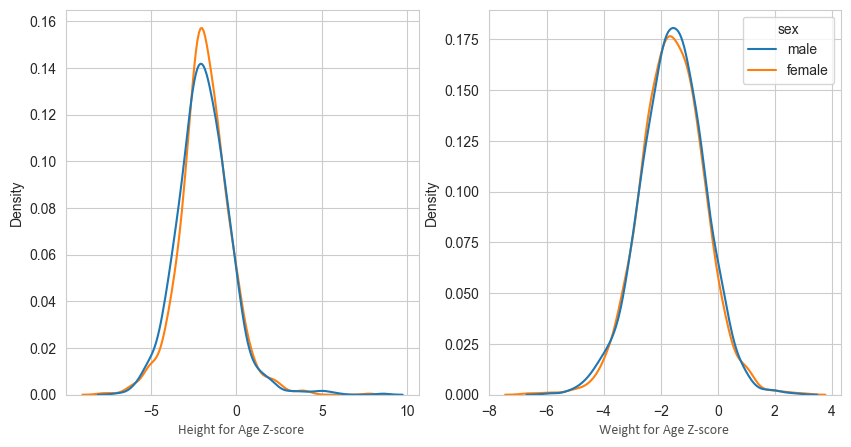

<Figure size 640x480 with 0 Axes>

In [758]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))

sns.kdeplot(data=df_r1_anthr2, x="HAZ", hue="sex", ax=ax[0], legend=False)
ax[0].set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)

sns.kdeplot(data=df_r1_anthr2, x="WAZ", hue="sex", ax=ax[1], legend=True)
ax[1].set_xlabel("Weight for Age Z-score ", fontsize=10, color=font_color, **hfont)



#plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'r1-Z-score dist'
plt.savefig(os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)



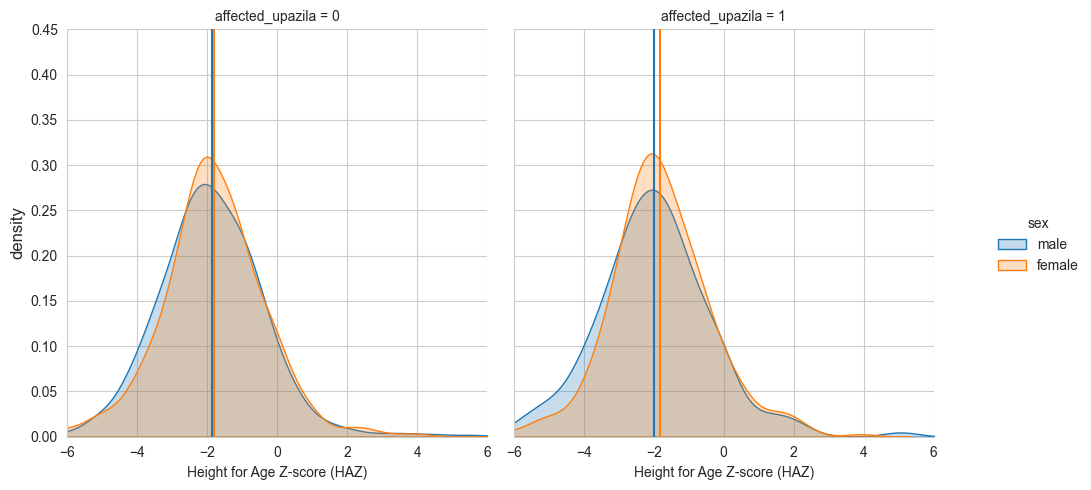

In [759]:
g = sns.FacetGrid(df_r1_anthr2, col="affected_upazila", hue="sex", margin_titles=True, ylim=(0, 0.45), xlim=(-6, 6),sharex=True, sharey=True, height=5, aspect=1)
g.map(sns.kdeplot, "HAZ",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'HAZ')

g.set_axis_labels("Height for Age Z-score (HAZ)")
g.set_ylabels('density', size=12)

filename="by_gender_distribution_haz_norm_r1"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

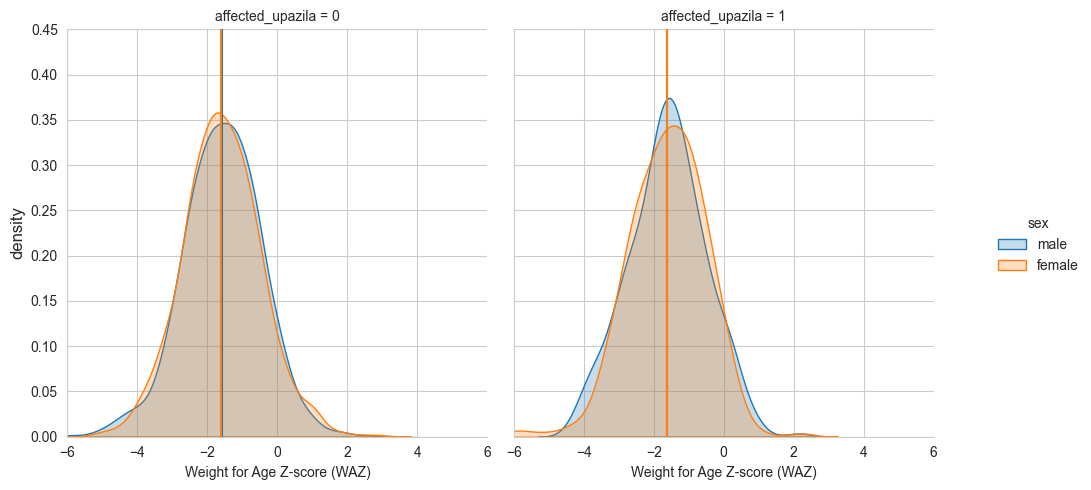

In [760]:
g = sns.FacetGrid(df_r1_anthr2, col="affected_upazila", hue="sex", margin_titles=True, ylim=(0, 0.45), xlim=(-6, 6),sharex=True, sharey=True,height=5, aspect=1)
g.map(sns.kdeplot, "WAZ",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'WAZ')

g.set_axis_labels("Weight for Age Z-score (WAZ)")
g.set_ylabels('density', size=12)

filename="by_gender_distribution_waz_norm_r1"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

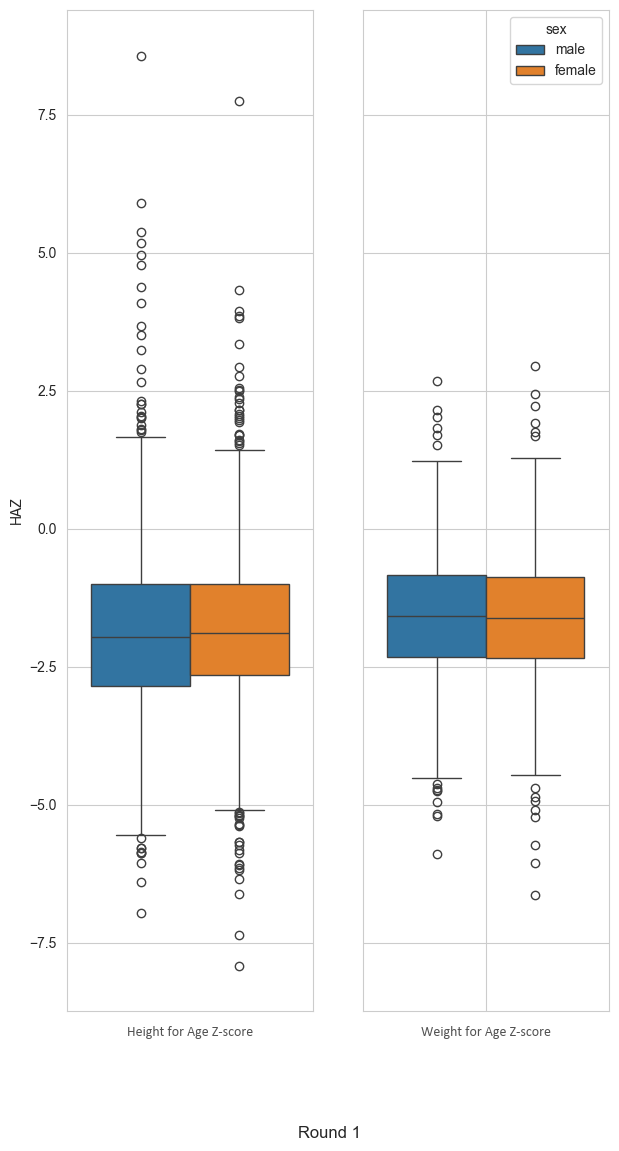

<Figure size 640x480 with 0 Axes>

In [761]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True, sharey=True, figsize=(7,13))

sns.boxplot(data=df_r1_anthr2, y="HAZ", hue="sex", ax=ax[0], legend=False)
ax[0].set_xlabel("Height for Age Z-score", fontsize=10, color=font_color, **hfont)


sns.boxplot(data=df_r1_anthr2, y="WAZ", hue="sex", ax=ax[1])
ax[1].set_xlabel("Weight for Age Z-score", fontsize=10, color=font_color, **hfont)

fig.supxlabel('Round 1')

plt.grid(True)
plt.show()

filename = 'r1_boxplot'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

### Round 2

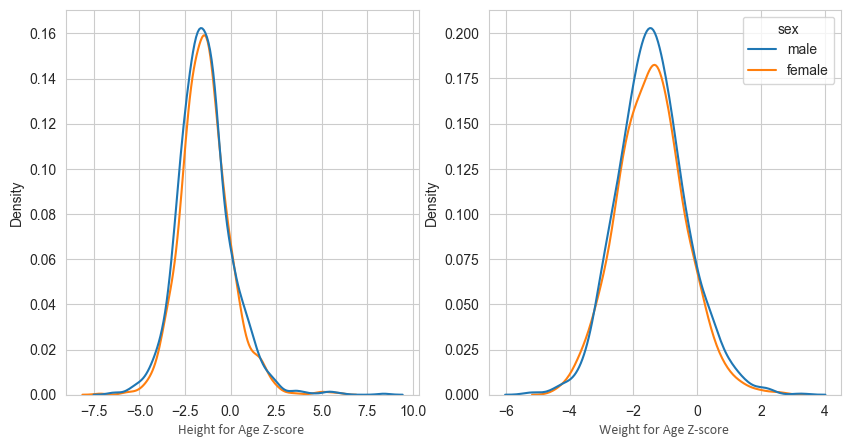

<Figure size 640x480 with 0 Axes>

In [762]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))

sns.kdeplot(data=df_r2_anthr2, x="HAZ", hue="sex", ax=ax[0], legend=False)
ax[0].set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)

sns.kdeplot(data=df_r2_anthr2, x="WAZ", hue="sex", ax=ax[1], legend=True)
ax[1].set_xlabel("Weight for Age Z-score ", fontsize=10, color=font_color, **hfont)



#plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'r2-Z-score dist'
plt.savefig(os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

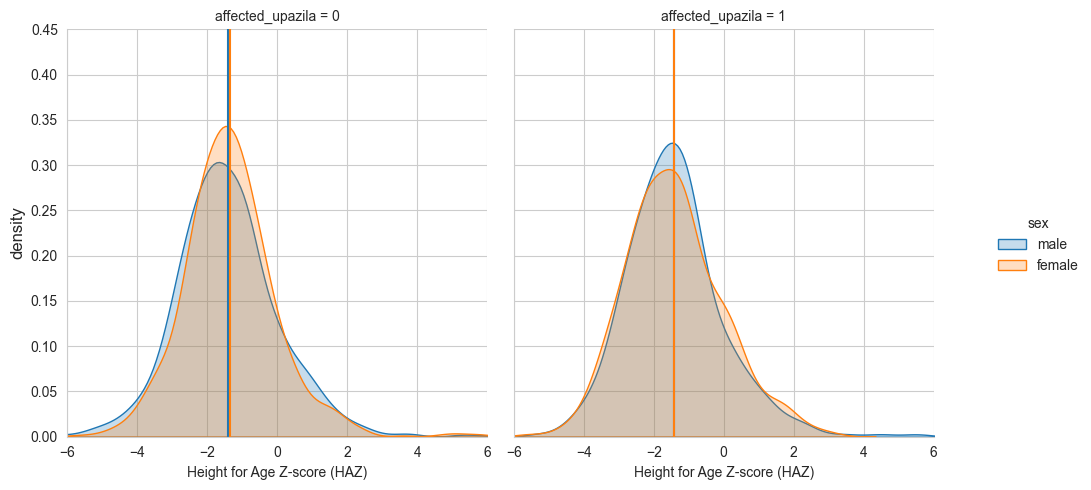

In [763]:
g = sns.FacetGrid(df_r2_anthr2, col="affected_upazila", hue="sex", margin_titles=True, ylim=(0, 0.45), xlim=(-6, 6),sharex=True, sharey=True, height=5, aspect=1)
g.map(sns.kdeplot, "HAZ",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'HAZ')

g.set_axis_labels("Height for Age Z-score (HAZ)")
g.set_ylabels('density', size=12)

filename="by_gender_distribution_haz_norm_r2"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

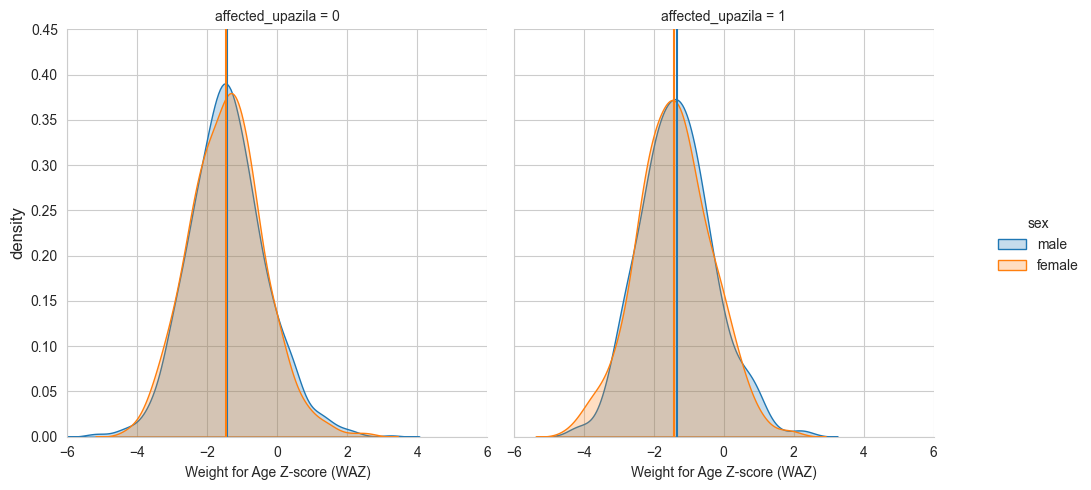

In [764]:
g = sns.FacetGrid(df_r2_anthr2, col="affected_upazila", hue="sex", margin_titles=True, ylim=(0, 0.45), xlim=(-6, 6),sharex=True, sharey=True,height=5, aspect=1)
g.map(sns.kdeplot, "WAZ",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'WAZ')

g.set_axis_labels("Weight for Age Z-score (WAZ)")
g.set_ylabels('density', size=12)

filename="by_gender_distribution_waz_norm_r2"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

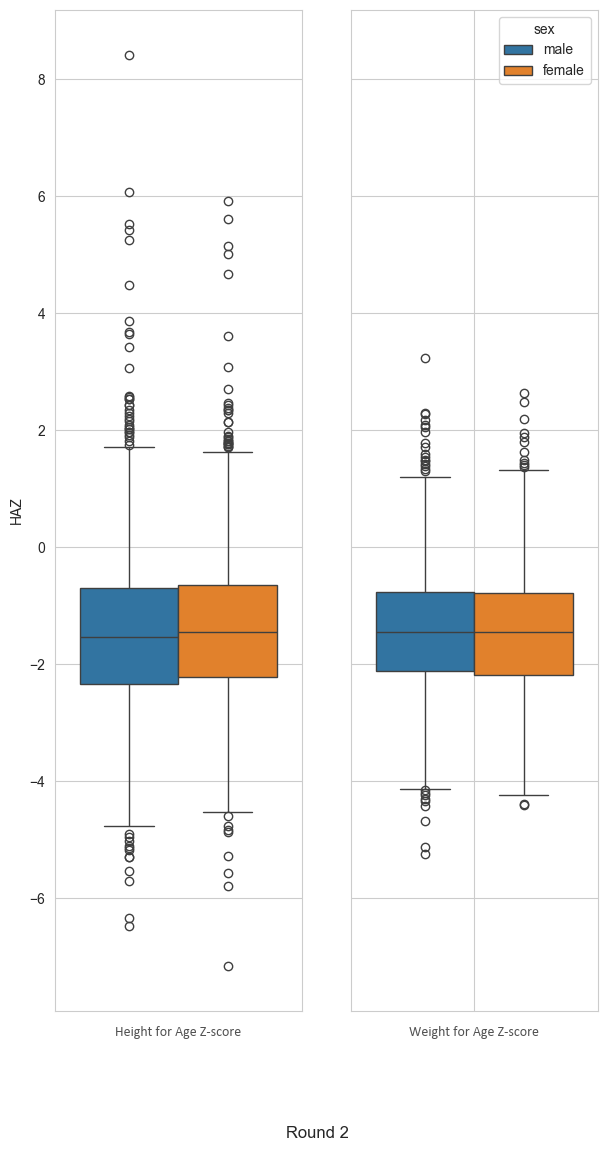

<Figure size 640x480 with 0 Axes>

In [765]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True, sharey=True, figsize=(7,13))

sns.boxplot(data=df_r2_anthr2, y="HAZ", hue="sex", ax=ax[0], legend=False)
ax[0].set_xlabel("Height for Age Z-score", fontsize=10, color=font_color, **hfont)


sns.boxplot(data=df_r2_anthr2, y="WAZ", hue="sex", ax=ax[1])
ax[1].set_xlabel("Weight for Age Z-score", fontsize=10, color=font_color, **hfont)

fig.supxlabel('Round 2')

plt.grid(True)
plt.show()

filename = 'r2_boxplot'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

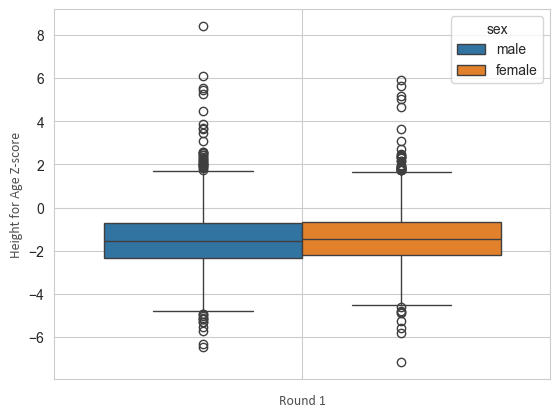

<Figure size 640x480 with 0 Axes>

In [766]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

g1 = sns.boxplot(data=df_r2_anthr2, y="HAZ", hue="sex")

g1.set_xlabel("Round 1", fontsize=10, color=font_color, **hfont)
g1.set_ylabel("Height for Age Z-score", fontsize=10, color=font_color, **hfont)


#plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'HAZ_r1'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

Text(0.5, 1.0, '')

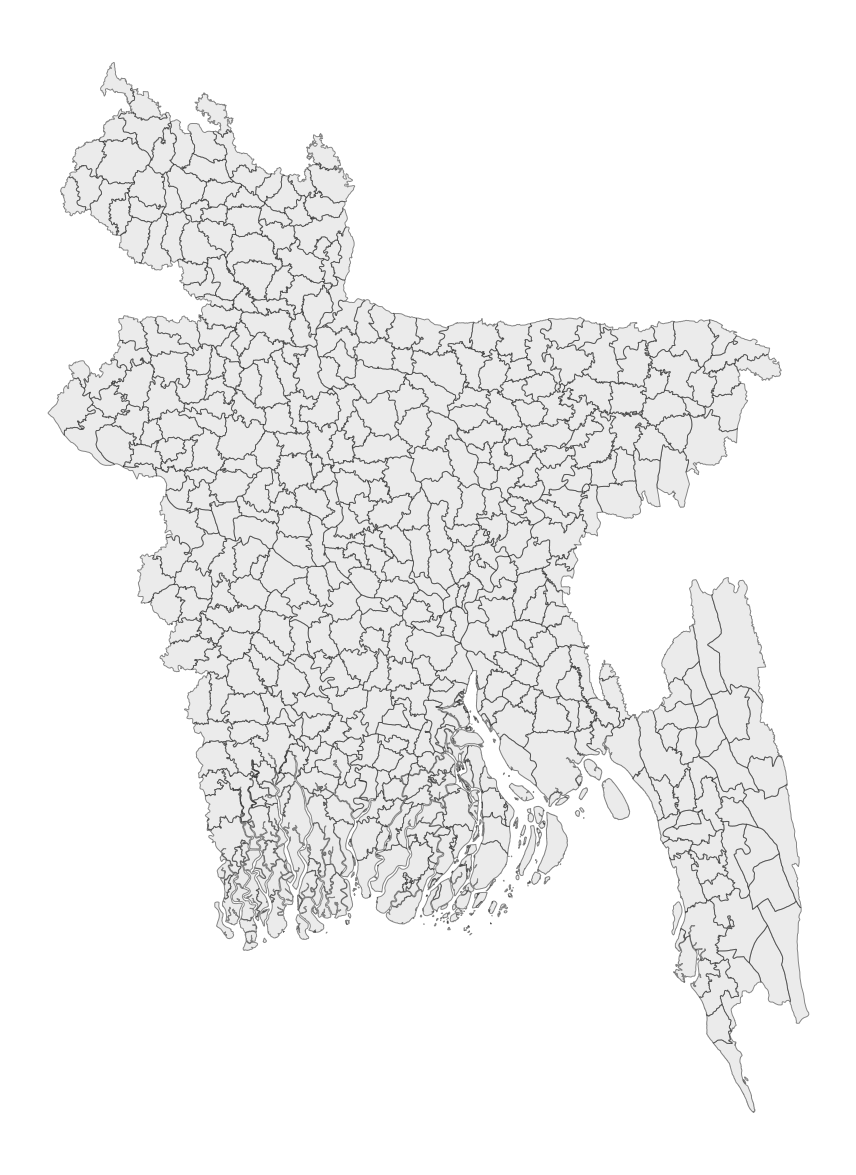

In [ ]:


# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(figsize=(15,15))
#bgd_adm.apply(lambda x: ax.annotate(text=x['NAME_3'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
bgd_plot=bgd_adm.plot(ax=ax, color='lightgrey', edgecolor='black',lw=0.7, alpha=0.45)

# Sans axe 
ax.axis('off')

# using set_facecolor() method
ax.set_facecolor("red")

# Rajouter le titre
ax.set_title('', fontsize=23)

# Rajouter les coordonnées GPS des points sur la carte
#csm = shp_2007.plot(ax=bgd_plot, column='DHSREGNA', cmap='Paired', markersize=20, legend=True)

In [ ]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))

sns.kdeplot(data=df_r2_anthr2, x="HAZ", hue="sex", ax=ax[0], legend=False)
ax[0].set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)

sns.kdeplot(data=df_r2_anthr2, x="WAZ", hue="sex", ax=ax[1], legend=True)
ax[1].set_xlabel("Weight for Age Z-score ", fontsize=10, color=font_color, **hfont)


#plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'r2 - Z-score dist'
plt.savefig(os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

Text(0.5, 1.0, '')

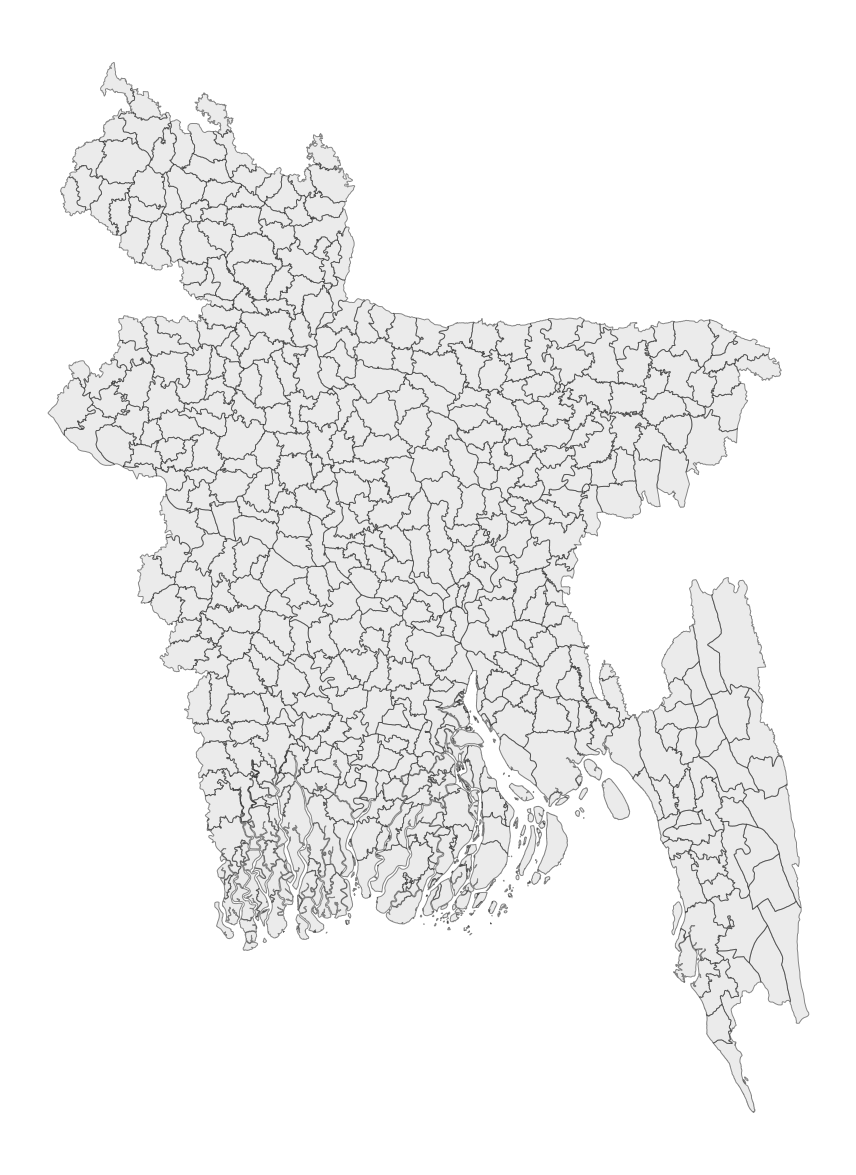

In [138]:


# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(figsize=(15,15))
#bgd_adm.apply(lambda x: ax.annotate(text=x['NAME_3'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
bgd_plot=bgd_adm.plot(ax=ax, color='lightgrey', edgecolor='black',lw=0.7, alpha=0.45)

# Sans axe 
ax.axis('off')

# using set_facecolor() method
ax.set_facecolor("red")

# Rajouter le titre
ax.set_title('', fontsize=23)

# Rajouter les coordonnées GPS des points sur la carte
#csm = shp_2007.plot(ax=bgd_plot, column='DHSREGNA', cmap='Paired', markersize=20, legend=True)

In [ ]:
lst_outcomes=['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO']
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: x.replace(['Age in days out of plausible limits','Flagged cases','Missing','NIU (not in universe)'], np.NaN))
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: pd.to_numeric(x, errors='coerce'))


C:\Users\ASUS\AppData\Local\Temp\ipykernel_20172\3933648467.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[lst_outcomes] = df[lst_outcomes].apply(lambda x: x.replace(['Age in days out of plausible limits','Flagged cases','Missing','NIU (not in universe)'], np.NaN))


In [ ]:
lst_depvar=['KIDAGEMO', 'KIDSEX']
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: x.replace(['Age in days out of plausible limits','Flagged cases','Missing','NIU (not in universe)'], np.NaN))
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [ ]:
df = df.assign(**{col: df[col] / 100 for col in lst_outcomes})


In [ ]:
df.describe().T

count          mean           std           min           25%  \
YEAR        36529.0  2.007593e+03  4.992744e+00  2.000000e+03  2.004000e+03   
IDHSPSU     36529.0  5.005108e+09  1.424356e+06  5.003000e+09  5.004000e+09   
IDHSSTRATA  36529.0  5.005109e+08  1.424009e+05  5.003000e+08  5.004001e+08   
PSU         36529.0  2.586824e+02  1.674505e+02  1.000000e+00  1.160000e+02   
STRATA      36529.0  5.504279e+01  5.331771e+01  1.000000e+00  1.500000e+01   
DOMAIN      36529.0  9.702182e+00  7.195199e+00  0.000000e+00  3.000000e+00   
HHNUM       36529.0  7.425905e+01  6.913679e+01  1.000000e+00  2.800000e+01   
CLUSTERNO   36529.0  2.586824e+02  1.674505e+02  1.000000e+00  1.160000e+02   
LINENO      36529.0  2.904596e+00  2.040628e+00  1.000000e+00  2.000000e+00   
BIDX        36529.0  1.203154e+00  4.406707e-01  1.000000e+00  1.000000e+00   
PERWEIGHT   36529.0  1.009585e+00  6.127827e-01  0.000000e+00  6.058780e-01   
KIDWT       36529.0  1.885530e+03  1.197870e+03  0.000000e+00  1.035000e+03   
AWFACTT     36529.0  1.213652e+00  5.956322e-01  1.000000e+00  1.020000e+00   
AWFACTU     36529.0  1.224552e+02  6.133651e+01  1.000000e+02  1.020000e+02   
AWFACTR     36529.0  1.227649e+02  6.792568e+01  1.000000e+02  1.010000e+02   
AWFACTE     36529.0  1.190608e+02  6.133814e+01  1.000000e+02  1.010000e+02   
AWFACTW     29697.0  1.204920e+02  7.505567e+01  1.000000e+02  1.010000e+02   
DVWEIGHT     6150.0  4.056287e-01  6.625463e-01  0.000000e+00  0.000000e+00   
AGE         36529.0  2.566887e+01  6.122223e+00  1.300000e+01  2.100000e+01   
WEALTHS     36529.0 -7.684462e-02  9.553516e-01 -8.000000e+00 -7.653600e-01   
HWHAZWHO    31200.0 -1.758540e+00  1.386030e+00 -6.000000e+00 -2.650000e+00   
HWWAZWHO    31200.0 -1.650520e+00  1.135365e+00 -5.860000e+00 -2.400000e+00   
HWWHZWHO    31200.0 -9.191949e-01  1.128954e+00 -5.000000e+00 -1.620000e+00   
HWBMIZWHO   31200.0 -7.664663e-01  1.140788e+00 -4.990000e+00 -1.460000e+00   

                     50%           75%           max  
YEAR        2.007000e+03  2.011000e+03  2.014000e+03  
IDHSPSU     5.005000e+09  5.006001e+09  5.007001e+09  
IDHSSTRATA  5.005001e+08  5.006000e+08  5.007000e+08  
PSU         2.320000e+02  3.930000e+02  6.000000e+02  
STRATA      2.100000e+01  9.800000e+01  1.790000e+02  
DOMAIN      1.000000e+01  1.600000e+01  2.200000e+01  
HHNUM       5.900000e+01  9.500000e+01  5.330000e+02  
CLUSTERNO   2.320000e+02  3.930000e+02  6.000000e+02  
LINENO      2.000000e+00  3.000000e+00  2.700000e+01  
BIDX        1.000000e+00  1.000000e+00  5.000000e+00  
PERWEIGHT   9.226440e-01  1.332812e+00  1.419449e+01  
KIDWT       1.619000e+03  2.558000e+03  2.632400e+04  
AWFACTT     1.080000e+00  1.190000e+00  7.368000e+01  
AWFACTU     1.080000e+02  1.200000e+02  6.887000e+03  
AWFACTR     1.070000e+02  1.200000e+02  6.336000e+03  
AWFACTE     1.040000e+02  1.170000e+02  7.201000e+03  
AWFACTW     1.050000e+02  1.200000e+02  8.831000e+03  
DVWEIGHT    0.000000e+00  5.567060e-01  6.122211e+00  
AGE         2.500000e+01  2.900000e+01  4.900000e+01  
WEALTHS    -3.952700e-01  3.239800e-01  8.000000e+00  
HWHAZWHO   -1.790000e+00 -9.100000e-01  5.840000e+00  
HWWAZWHO   -1.680000e+00 -9.400000e-01  4.740000e+00  
HWWHZWHO   -9.400000e-01 -2.500000e-01  4.910000e+00  
HWBMIZWHO  -7.750000e-01 -8.000000e-02  5.000000e+00

In [ ]:
df['YEAR'] = df['YEAR'].astype("category")

In [ ]:

# duplication
df[df.duplicated()]

Empty DataFrame
Columns: [SAMPLE, SAMPLESTR, COUNTRY, YEAR, IDHSPID, IDHSHID, DHSID, IDHSPSU, IDHSSTRATA, CASEID, HHID, PSU, STRATA, DOMAIN, HHNUM, CLUSTERNO, LINENO, BIDX, PERWEIGHT, KIDWT, AWFACTT, AWFACTU, AWFACTR, AWFACTE, AWFACTW, DVWEIGHT, URBAN, GEO_BD1994_2014, GEO_BD1997, GEO_BD2000, GEO_BD2004, GEO_BD2007, GEO_BD2011, GEO_BD2014, AGE, AGE5YEAR, RESIDENT, RELIGION, MARSTAT, CHEB, CURRWORK, WEALTHQ, WEALTHS, EDUCLVL, EDYRTOTAL, KIDSEX, LINENOKID, KIDAGEMO, HWWEIGHT, HWHEIGHT, HWWHYNOTMEAS, HWDAYOFBIRTH, HWHAZWHO, HWWAZWHO, HWWHZWHO, HWBMIZWHO, born_after]
Index: []

[0 rows x 57 columns]

**Observations**:
No duplicate observations.

## Exploratory Data Analysis

Now that we have an understanding of the business problem we want to solve, and we have loaded the datasets, the next step to follow is to have a better understanding of the dataset, i.e., what is the distribution of the variables, what are different relationships that exist between variables, etc. If there are any data anomalies like missing values or outliers, how do we treat them to prepare the dataset for building the model?

Let's check the percentage of missing values using the below code.

In [ ]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df.isna().sum()/df.isna().count()*100,2),'Nbr of Missing Values':df.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  Nbr of Missing Values
GEO_BD1997                    100.00                  36529
DVWEIGHT                       83.16                  30379
GEO_BD2007                     83.16                  30379
GEO_BD2000                     81.30                  29697
GEO_BD2004                     81.09                  29621
GEO_BD2014                     78.41                  28643
GEO_BD2011                     76.04                  27776
AWFACTW                        18.70                   6832
LINENOKID                      18.70                   6832
HWWAZWHO                       14.59                   5329
HWBMIZWHO                      14.59                   5329
HWWHZWHO                       14.59                   5329
HWHAZWHO                       14.59                   5329
MARSTAT                         0.00                      0
AGE                             0.00                      0
AGE5YEAR                        0.00                      0
RESIDENT                        0.00                      0
RELIGION                        0.00                      0
CURRWORK                        0.00                      0
CHEB                            0.00                      0
WEALTHQ                         0.00                      0
EDUCLVL                         0.00                      0
EDYRTOTAL                       0.00                      0
KIDSEX                          0.00                      0
KIDAGEMO                        0.00                      0
HWWEIGHT                        0.00                      0
HWHEIGHT                        0.00                      0
HWWHYNOTMEAS                    0.00                      0
HWDAYOFBIRTH                    0.00                      0
WEALTHS                         0.00                      0
SAMPLE                          0.00                      0
SAMPLESTR                       0.00                      0
GEO_BD1994_2014                 0.00                      0
COUNTRY                         0.00                      0
YEAR                            0.00                      0
IDHSPID                         0.00                      0
IDHSHID                         0.00                      0
DHSID                           0.00                      0
IDHSPSU                         0.00                      0
IDHSSTRATA                      0.00                      0
CASEID                          0.00                      0
HHID                            0.00                      0
PSU                             0.00                      0
STRATA                          0.00                      0
DOMAIN                          0.00                      0
HHNUM                           0.00                      0
CLUSTERNO                       0.00                      0
LINENO                          0.00                      0
BIDX                            0.00                      0
PERWEIGHT                       0.00                      0
KIDWT                           0.00                      0
AWFACTT                         0.00                      0
AWFACTU                         0.00                      0
AWFACTR                         0.00                      0
AWFACTE                         0.00                      0
URBAN                           0.00                      0
born_after                      0.00                      0

In [ ]:

#outcome variable 
outcomes_cols = ['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO']



In [ ]:
#Summarize data
df.describe().T

df.columns

Index(['SAMPLE', 'SAMPLESTR', 'COUNTRY', 'YEAR', 'IDHSPID', 'IDHSHID', 'DHSID',
       'IDHSPSU', 'IDHSSTRATA', 'CASEID', 'HHID', 'PSU', 'STRATA', 'DOMAIN',
       'HHNUM', 'CLUSTERNO', 'LINENO', 'BIDX', 'PERWEIGHT', 'KIDWT', 'AWFACTT',
       'AWFACTU', 'AWFACTR', 'AWFACTE', 'AWFACTW', 'DVWEIGHT', 'URBAN',
       'GEO_BD1994_2014', 'GEO_BD1997', 'GEO_BD2000', 'GEO_BD2004',
       'GEO_BD2007', 'GEO_BD2011', 'GEO_BD2014', 'AGE', 'AGE5YEAR', 'RESIDENT',
       'RELIGION', 'MARSTAT', 'CHEB', 'CURRWORK', 'WEALTHQ', 'WEALTHS',
       'EDUCLVL', 'EDYRTOTAL', 'KIDSEX', 'LINENOKID', 'KIDAGEMO', 'HWWEIGHT',
       'HWHEIGHT', 'HWWHYNOTMEAS', 'HWDAYOFBIRTH', 'HWHAZWHO', 'HWWAZWHO',
       'HWWHZWHO', 'HWBMIZWHO', 'born_after'],
      dtype='object')

In [ ]:
df.YEAR.value_counts(normalize=True)

YEAR
2011    0.239618
2014    0.215883
2004    0.189110
2000    0.187029
2007    0.168359
Name: proportion, dtype: float64

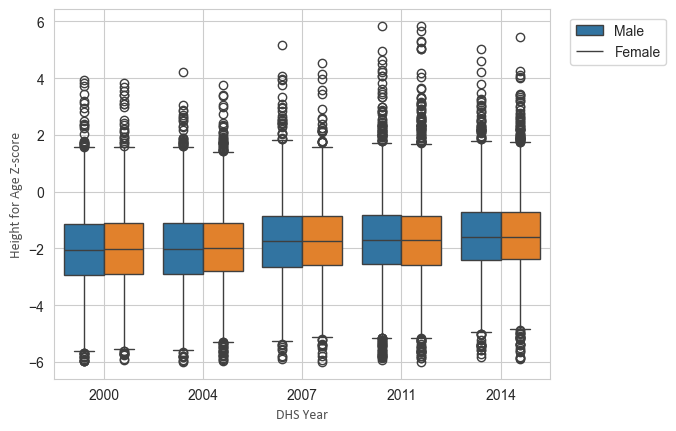

<Figure size 640x480 with 0 Axes>

In [ ]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

g1 = sns.boxplot(data=df, x="YEAR", y="HWHAZWHO", hue="KIDSEX")

g1.set_xlabel("DHS Year", fontsize=10, color=font_color, **hfont)
g1.set_ylabel("Height for Age Z-score", fontsize=10, color=font_color, **hfont)



#title = 'Average Foreign Exchange Rates, 2000–2019'
#fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
#subtitle = 'Source: Author own calculation'
#plt.title(subtitle, fontsize=18, pad=10, color=font_color, **hfont)
#plt.subplots_adjust(top=0.85)

# title
#new_title = ''
#g1.legend.set_title(new_title)
# replace labels
# new_labels = ['Urban 555', 'Rural']
# for t, l in zip(g1.texts, new_labels):
#     t.set_text(l)
plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Height for Age Z-score dist'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

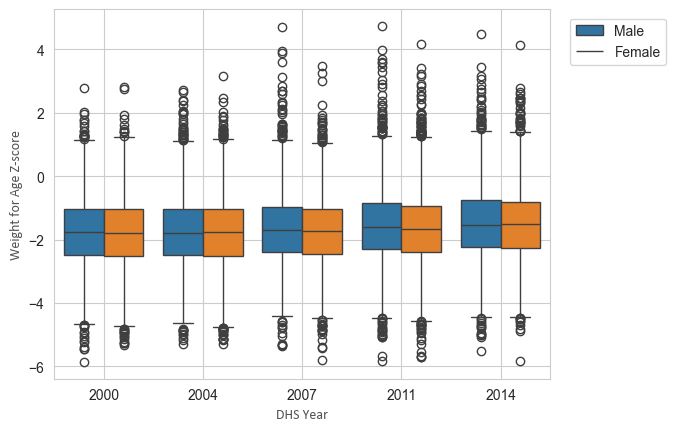

<Figure size 640x480 with 0 Axes>

In [ ]:
g2 = sns.boxplot(data=df, x="YEAR", y="HWWAZWHO", hue="KIDSEX")

g2.set_xlabel("DHS Year", fontsize=10, color=font_color, **hfont)
g2.set_ylabel("Weight for Age Z-score", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Weight for Age Z-score dist'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

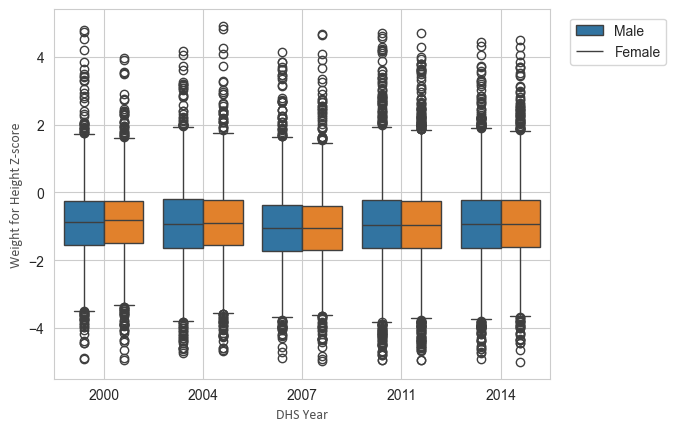

<Figure size 640x480 with 0 Axes>

In [ ]:
g3 = sns.boxplot(data=df, x="YEAR", y="HWWHZWHO", hue="KIDSEX")
g3.set_xlabel("DHS Year", fontsize=10, color=font_color, **hfont)
g3.set_ylabel("Weight for Height Z-score", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Weight for Height Z-score dist'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

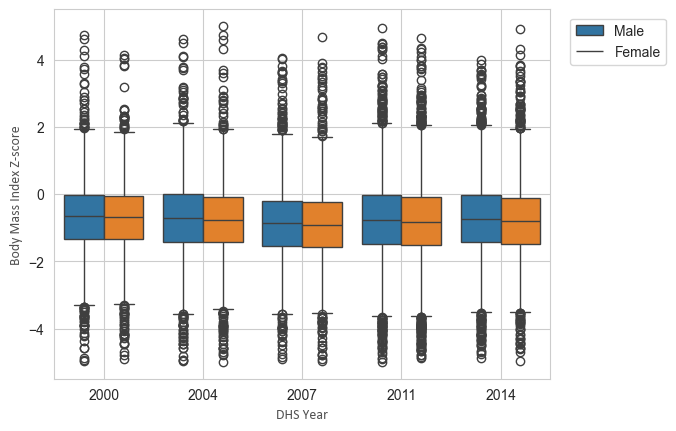

<Figure size 640x480 with 0 Axes>

In [ ]:
g4 = sns.boxplot(data=df, x="YEAR", y="HWBMIZWHO", hue="KIDSEX")
g4.set_xlabel("DHS Year", fontsize=10, color=font_color, **hfont)
g4.set_ylabel("Body Mass Index Z-score", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Body Mass Index Z-score dist'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

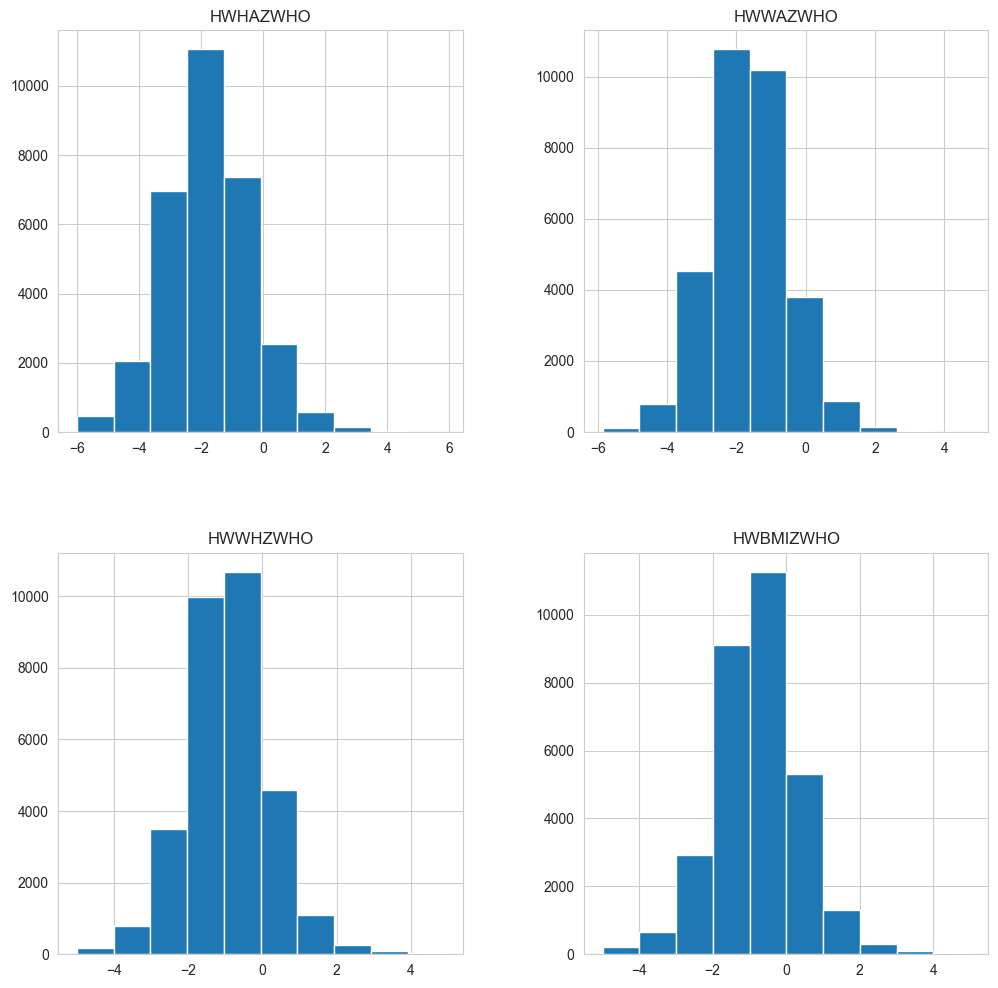

In [ ]:
#title=['Height for Age Z-score','Weight for Age Z-score','Weight for Height Z-score','Body Mass Index Z-score']
df[['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO']].hist(figsize=(12,12))

#plt.title(title, fontsize=18, pad=10, color=font_color, **hfont)
plt.show()

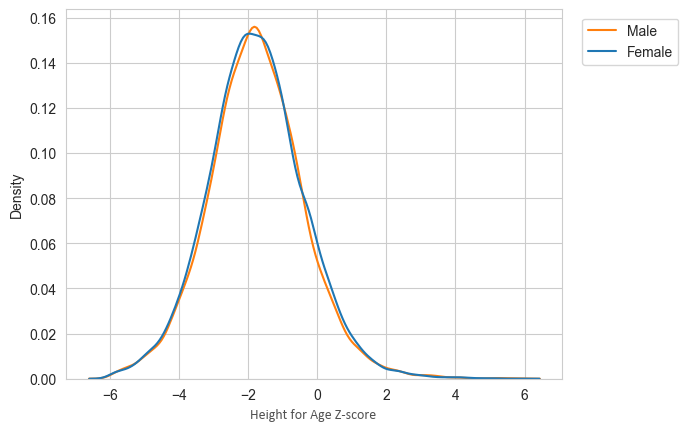

<Figure size 640x480 with 0 Axes>

In [ ]:
g5 = sns.kdeplot(data=df, x="HWHAZWHO", hue="KIDSEX")
g5.set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Body Mass Index Z-score dist'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

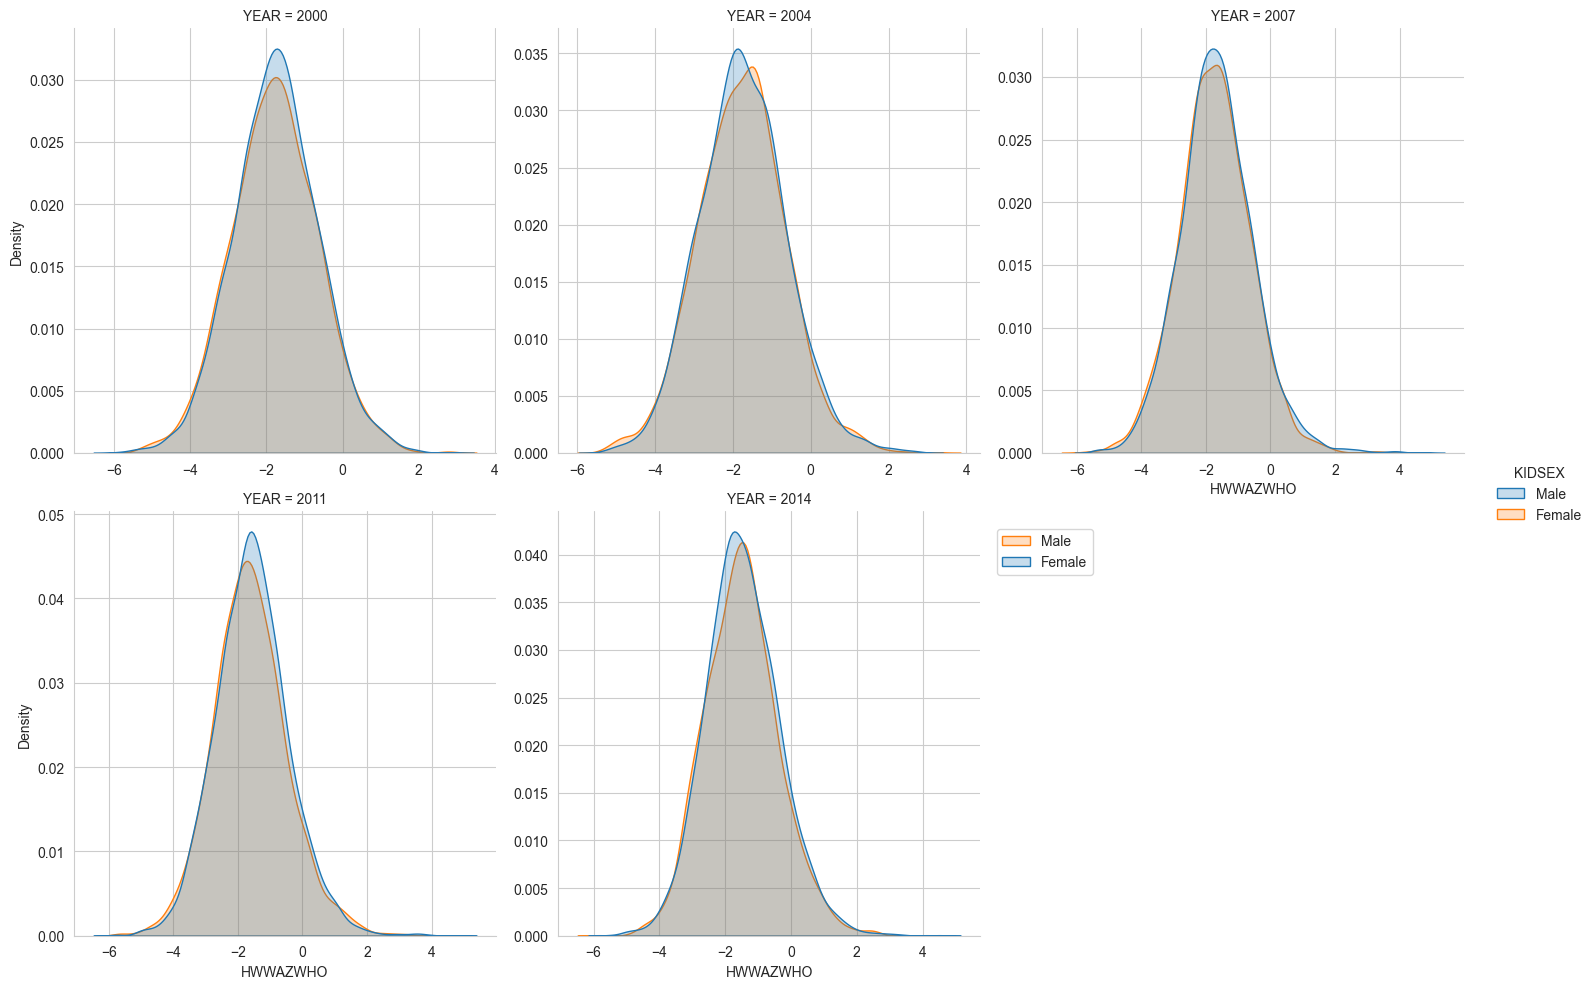

In [ ]:
#g10 = sns.FacetGrid(data=df, col='YEAR', hue='KIDSEX', col_wrap=3)

#g10.map(sns.kdeplot, x="HWWAZWHO", cut=0, fill=True,  alpha=1,  clip=(-5, 5))
# g5.set_xlabel("Weight for Age Z-score", fontsize=10, color=font_color, **hfont)


# plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
# plt.grid(True)
# plt.show()

g5 = sns.displot(data=df, col='YEAR', hue='KIDSEX', x='HWWAZWHO', kind='kde', col_wrap=3,fill=True, facet_kws={'sharey': False, 'sharex': False})
# control the title of each facet
#g5 = g5.set_titles("{col_name}")
#g5.set_xlabel("Weight for Age Z-score", fontsize=10, color=font_color, **hfont)
plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
filename = 'Weight for Age Z-score density'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

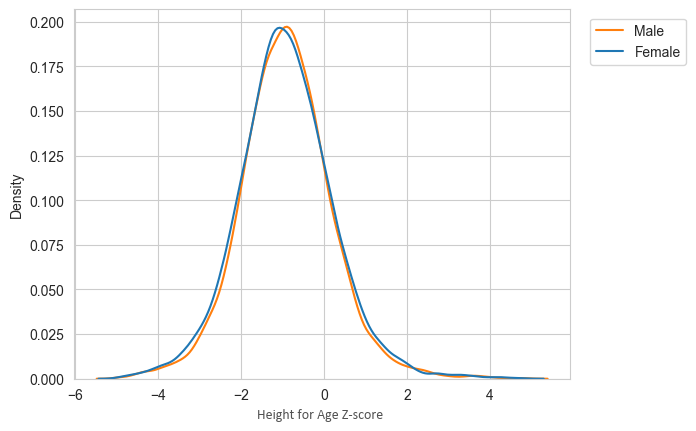

<Figure size 640x480 with 0 Axes>

In [ ]:
g5 = sns.kdeplot(data=df, x='HWWHZWHO', hue="KIDSEX")
g5.set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Weight for Height Z-score density'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

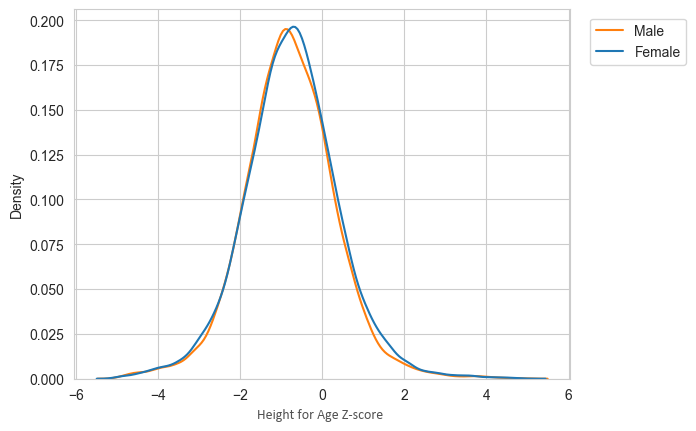

<Figure size 640x480 with 0 Axes>

In [ ]:
g5 = sns.kdeplot(data=df, x='HWBMIZWHO', hue="KIDSEX")
g5.set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Body Mass Index Z-score density'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

## Spatial data analysis

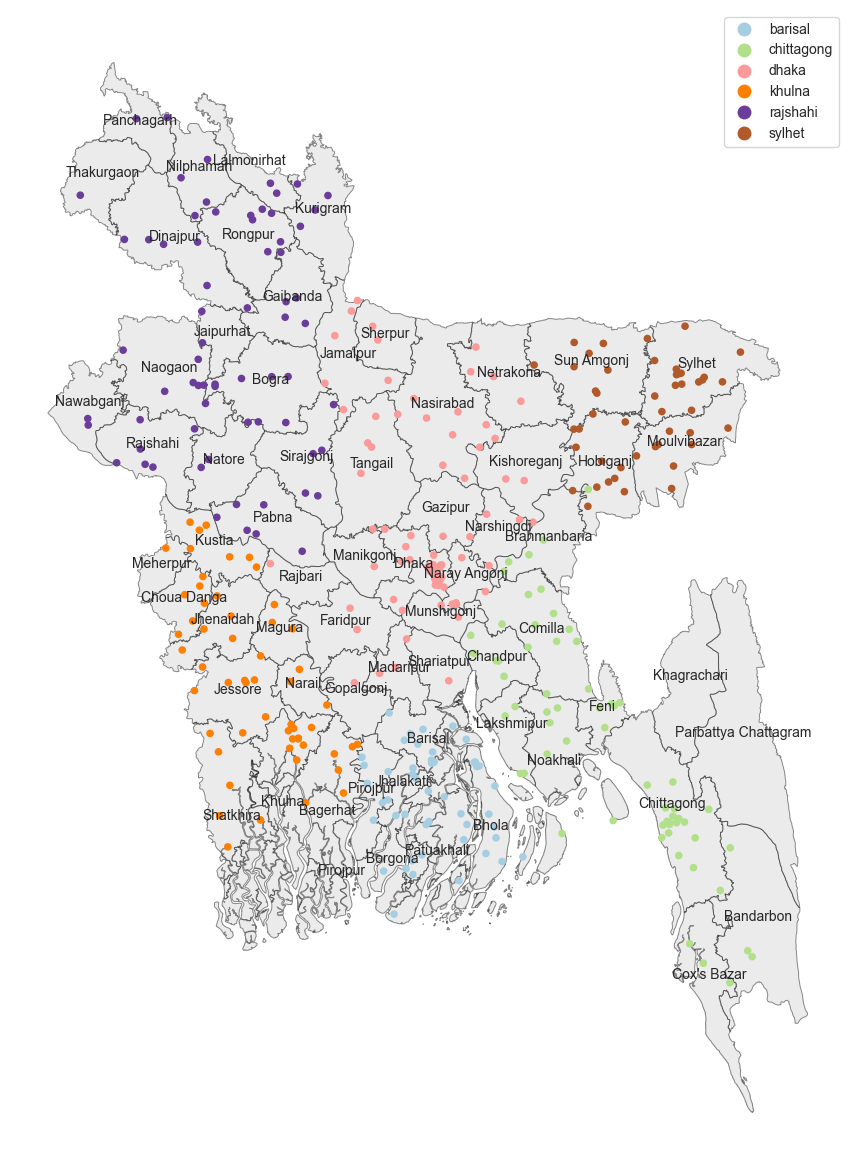

In [ ]:
# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(figsize=(15,15))
bgd_adm.apply(lambda x: ax.annotate(text=x['NAME_2'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
bgd_plot=bgd_adm.plot(ax=ax, color='lightgrey', edgecolor='black',lw=0.7, alpha=0.45)

# Sans axe 
ax.axis('off')

# using set_facecolor() method
ax.set_facecolor("red")

# Rajouter le titre
ax.set_title('', fontsize=23)

# Rajouter les coordonnées GPS des points sur la carte
csm = shp_2007.plot(ax=bgd_plot, column='DHSREGNA', cmap='Paired', markersize=20, legend=True)

In [ ]:
shp_2004 = shp_2004.drop(shp_2004[(shp_2004['LATNUM']==0) & (shp_2004['LONGNUM']==0)].index, axis=0)
shp_2014 = shp_2014.drop(shp_2014[(shp_2014['LATNUM']==0) & (shp_2014['LONGNUM']==0)].index, axis=0)

# resetting the DataFrame index
shp_2004 = shp_2004.reset_index()
shp_2014 = shp_2014.reset_index()

In [ ]:
# building and id for each

#bgd_adm.assign(ID = str(bgd_adm["ID_1"] + bgd_adm["ID_2"]))

bgd_adm["ID"] = bgd_adm["ID_1"].astype("str") + bgd_adm["ID_2"].astype("str")
bgd_adm["ID"] = bgd_adm["ID"].astype("str")


In [ ]:
# list of the most exposed district names
housing_dmg = housing_dmg.assign(damaged_hh = housing_dmg["Fully Damaged Households"] / housing_dmg["District Total Population 2007 est."])
# list of the most exposed district names in the list 
housing_dmg_2 = housing_dmg_2.assign(damaged_hh = housing_dmg_2["No. of Affected People"] / housing_dmg_2["District Total Population 2007 est."])
#lst_mst_affctd = housing_dmg[housing_dmg["Fully Damaged Households"] >= housing_dmg["Fully Damaged Households"].quantile(1/5)]["District corrected"].astype("str")


c:\Users\ASUS\Dropbox\PhD thesis\chapitre_2\PhD-Chapter-2\my_venv\Lib\site-packages\mapclassify\classifiers.py:1592: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 5.
  self.bins = quantile(y, k=k)
c:\Users\ASUS\Dropbox\PhD thesis\chapitre_2\PhD-Chapter-2\my_venv\Lib\site-packages\mapclassify\classifiers.py:1592: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 5.
  self.bins = quantile(y, k=k)


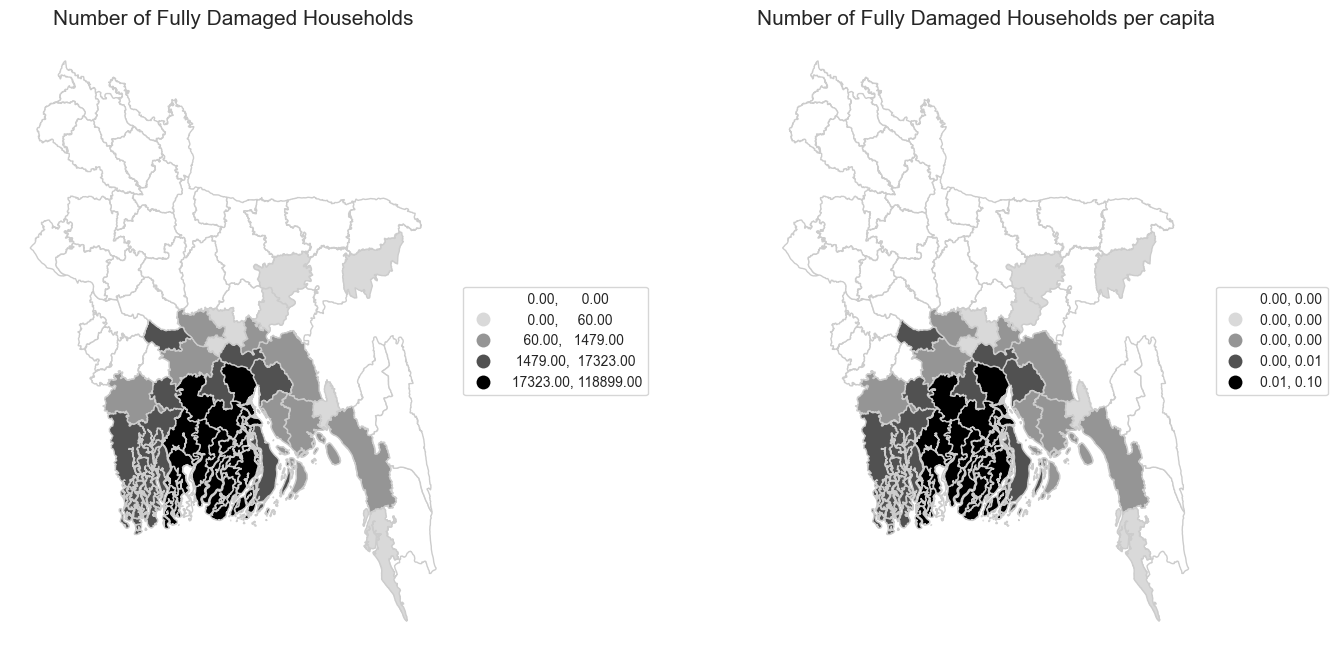

In [ ]:
# Explicitly specifying the columns for joining
merged = bgd_adm.merge(housing_dmg, left_on='ID', right_on='ID_adm', how='left')

# Replace na by 0

merged["Fully Damaged Households"] = merged["Fully Damaged Households"].fillna(0)
merged["damaged_hh"] = merged["damaged_hh"].fillna(0)
# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(17.8,8))
cmap = 'Greys'
merged.plot(column="Fully Damaged Households", scheme="quantiles", k=8, cmap=cmap, ax=ax[0], edgecolor='0.8', legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": False})
merged.plot(column="damaged_hh", scheme="quantiles", k=8, cmap=cmap, ax = ax[1], edgecolor='0.8', legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": False})
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Number of Fully Damaged Households', fontdict={'fontsize': '15'})
ax[1].set_title('Number of Fully Damaged Households per capita', fontdict={'fontsize': '15'})
# Create an annotation for the data source
#ax.annotate('Government of Bangladesh Report (2008)',xy=(0, 0))
#,xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='#555555'
# Create colorbar as a legend
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=merged["Fully Damaged Households"].astype("int64").min(), vmax=merged["Fully Damaged Households"].astype("int64").max()))

# Empty array for the data range
#sm._A = []
# Add the colorbar to the figure
#cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
#cbar = fig.colorbar(sm, cax=cbaxes)
filename="fully_damaged_hh"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

c:\Users\ASUS\Dropbox\PhD thesis\chapitre_2\PhD-Chapter-2\my_venv\Lib\site-packages\mapclassify\classifiers.py:1592: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 5.
  self.bins = quantile(y, k=k)
c:\Users\ASUS\Dropbox\PhD thesis\chapitre_2\PhD-Chapter-2\my_venv\Lib\site-packages\mapclassify\classifiers.py:1592: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 5.
  self.bins = quantile(y, k=k)


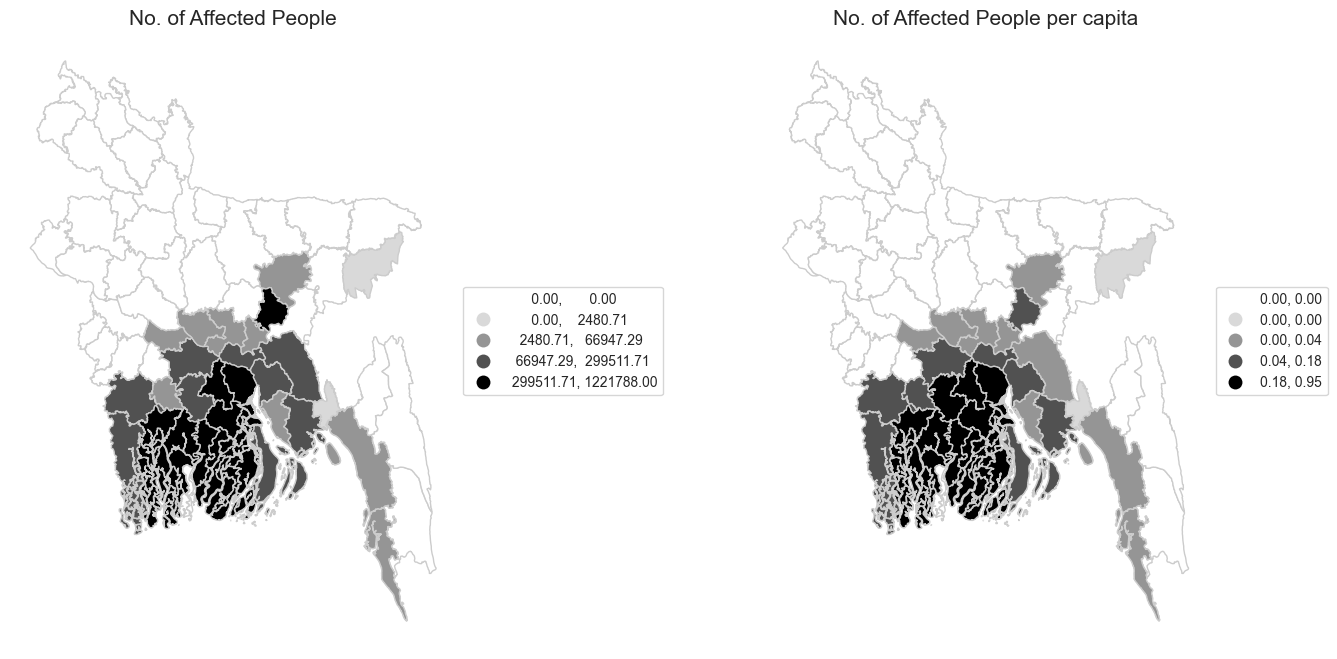

In [ ]:
# Explicitly specifying the columns for joining
merged_2 = bgd_adm.merge(housing_dmg_2, left_on='ID', right_on='ID_adm', how='left')

# Replace na by 0
merged_2["No. of Affected People"] = merged_2["No. of Affected People"].fillna(0)
merged_2["damaged_hh"] = merged_2["damaged_hh"].fillna(0)
# Représentation graphique des regions du Bangladesh
# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(17.8,8))
cmap = 'Greys'
merged_2.plot(column="No. of Affected People", scheme="quantiles", k=7, cmap=cmap, ax = ax[0], edgecolor='0.8', legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": False})
merged_2.plot(column="damaged_hh", scheme="quantiles", k=7, cmap=cmap, ax = ax[1], edgecolor='0.8', legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": False})
ax[0].axis('off')
ax[0].set_title('No. of Affected People', fontdict={'fontsize': '15'})
ax[1].axis('off')
ax[1].set_title('No. of Affected People per capita', fontdict={'fontsize': '15'})
# Create an annotation for the data source
#ax.annotate('Ministry of Food and Disaster Management (2007)',xy=(0, 0))

filename="affected_people_hh"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

In [ ]:
# import mapclassify as mc
# import geoplot as gplt
# fig, ax = plt.subplots(1, 1, figsize=(16, 12))
# scheme = mc.Quantiles(merged['Fully Damaged Households'], k=6)

# # Map
# gplt.choropleth(merged, 
#     hue="Fully Damaged Households", 
#     linewidth=.1,
#     scheme=scheme, cmap='inferno_r',
#     legend=True,
#     edgecolor='black',
#     ax=ax
# );

# ax.set_title('Unemployment rate in US counties', fontsize=13);

# fig, ax = plt.subplots()
# merged.plot(ax=ax,column='Fully Damaged Households',cmap='OrRd',scheme='quantiles',legend=True,legend_kwds=dict(loc='upper right',bbox_to_anchor=(1.5, .9),fontsize='small',title="Legend",frameon=False))
# ax.axis('off')

In [ ]:
#merged.loc[merged.index.get_loc(merged["Fully Damaged Households"].fillna(0).astype("int64").idxmin()) - 1, "Fully Damaged Households"]
merged = merged.sort_values(by="Fully Damaged Households", ascending=True)
merged.iloc[merged.index.get_loc(merged["Fully Damaged Households"].astype("int64").idxmin()) + 1]

merged[merged["District corrected"]=="Narshingdi"]

ID_0  ISO      NAME_0  ID_1 NAME_1  ID_2      NAME_2 TYPE_2 ENGTYPE_2  \
27    20  BGD  Bangladesh     3  Dhaka    28  Narshingdi   Zila  District   

   NL_NAME_2  ... ID_adm_2 District Total Population 2007 est.  \
27      None  ...    328.0                           2199341.0   

   Total Households Total Vulnerable Households Fully Damaged Households  \
27         382440.0                     19122.0                     24.0   

   Partially Damaged Households  Fully Damaged Vulnerable Households  \
27                       5280.0                                  1.0   

    Partially Damaged Vulnerable Households  \
27                                    264.0   

    Fully Damaged Non‐ vulnerable Households  \
27                                      23.0   

    Partially Damaged Non‐ Vulnerable Households  
27                                        5016.0  

[1 rows x 26 columns]

In [ ]:
print(bgd_adm.NAME_2.sort_values(ascending=True).to_markdown())

|    | NAME_2               |
|---:|:---------------------|
| 34 | Bagerhat             |
|  6 | Bandarbon            |
|  0 | Barisal              |
|  1 | Bhola                |
| 45 | Bogra                |
|  2 | Borgona              |
|  7 | Brahmanbaria         |
|  8 | Chandpur             |
|  9 | Chittagong           |
| 35 | Choua Danga          |
| 10 | Comilla              |
| 11 | Cox's Bazar          |
| 17 | Dhaka                |
| 53 | Dinajpur             |
| 18 | Faridpur             |
| 12 | Feni                 |
| 54 | Gaibanda             |
| 19 | Gazipur              |
| 20 | Gopalgonj            |
| 61 | Hobiganj             |
| 46 | Jaipurhat            |
| 21 | Jamalpur             |
| 36 | Jessore              |
|  3 | Jhalakati            |
| 37 | Jhenaidah            |
| 13 | Khagrachari          |
| 38 | Khulna               |
| 22 | Kishoreganj          |
| 55 | Kurigram             |
| 39 | Kustia               |
| 14 | Lakshmipur           |
| 56 | Lal

In [ ]:
merged.describe().T

count          mean  \
ID_0                                           65.0  2.000000e+01   
ID_1                                           65.0  3.676923e+00   
ID_2                                           65.0  3.300000e+01   
ID_adm_2                                       30.0  2.641000e+02   
District Total Population 2007 est.            30.0  2.436702e+06   
Total Households                               30.0  4.134120e+05   
Total Vulnerable Households                    30.0  2.067060e+04   
Fully Damaged Households                       65.0  8.691800e+03   
Partially Damaged Households                   30.0  3.190367e+04   
Fully Damaged Vulnerable Households            30.0  9.416667e+02   
Partially Damaged Vulnerable Households        30.0  1.595167e+03   
Fully Damaged Non‐ vulnerable Households       30.0  1.789063e+04   
Partially Damaged Non‐ Vulnerable Households   30.0  3.030853e+04   

                                                       std       min  \
ID_0                                          0.000000e+00      20.0   
ID_1                                          1.696575e+00       1.0   
ID_2                                          1.890767e+01       1.0   
ID_adm_2                                      1.753903e+02      11.0   
District Total Population 2007 est.           1.939569e+06  805308.0   
Total Households                              3.386602e+05  140020.0   
Total Vulnerable Households                   1.693301e+04    7001.0   
Fully Damaged Households                      2.302596e+04       0.0   
Partially Damaged Households                  4.203809e+04      89.0   
Fully Damaged Vulnerable Households           1.559341e+03       1.0   
Partially Damaged Vulnerable Households       2.101877e+03       4.0   
Fully Damaged Non‐ vulnerable Households      2.962613e+04      14.0   
Partially Damaged Non‐ Vulnerable Households  3.993619e+04      85.0   

                                                     25%        50%  \
ID_0                                               20.00       20.0   
ID_1                                                2.00        3.0   
ID_2                                               17.00       33.0   
ID_adm_2                                          210.25      320.0   
District Total Population 2007 est.           1373499.00  1922985.0   
Total Households                               232230.00   308050.0   
Total Vulnerable Households                     11611.50    15402.5   
Fully Damaged Households                            0.00        0.0   
Partially Damaged Households                     2730.00     6414.5   
Fully Damaged Vulnerable Households                25.50      160.5   
Partially Damaged Vulnerable Households           136.25      321.0   
Fully Damaged Non‐ vulnerable Households          482.25     3056.0   
Partially Damaged Non‐ Vulnerable Households     2593.75     6093.5   

                                                     75%        max  
ID_0                                               20.00       20.0  
ID_1                                                5.00        7.0  
ID_2                                               49.00       65.0  
ID_adm_2                                          330.25      763.0  
District Total Population 2007 est.           2708348.00  9701012.0  
Total Households                               456260.00  1788520.0  
Total Vulnerable Households                     22813.00    89426.0  
Fully Damaged Households                         1479.00   118899.0  
Partially Damaged Households                    63839.50   132369.0  
Fully Damaged Vulnerable Households              1121.75     5945.0  
Partially Damaged Vulnerable Households          3192.25     6618.0  
Fully Damaged Non‐ vulnerable Households        21308.75   112954.0  
Partially Damaged Non‐ Vulnerable Households    60647.25   125751.0

In [ ]:
pd.DataFrame(data={'% of Missing Values':round(merged.isna().sum()/merged.isna().count()*100,2),'Nbr of Missing Values':merged.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


% of Missing Values  \
NL_NAME_2                                                  100.00   
District                                                    53.85   
District corrected                                          53.85   
Fully Damaged Non‐ vulnerable Households                    53.85   
Partially Damaged Vulnerable Households                     53.85   
Fully Damaged Vulnerable Households                         53.85   
Partially Damaged Households                                53.85   
Total Vulnerable Households                                 53.85   
Total Households                                            53.85   
District Total Population 2007 est.                         53.85   
ID_adm_2                                                    53.85   
ID_adm                                                      53.85   
Partially Damaged Non‐ Vulnerable Households                53.85   
VARNAME_2                                                   53.85   
ISO                                                          0.00   
ID                                                           0.00   
geometry                                                     0.00   
ENGTYPE_2                                                    0.00   
TYPE_2                                                       0.00   
NAME_2                                                       0.00   
Fully Damaged Households                                     0.00   
ID_2                                                         0.00   
NAME_1                                                       0.00   
ID_1                                                         0.00   
NAME_0                                                       0.00   
ID_0                                                         0.00   

                                              Nbr of Missing Values  
NL_NAME_2                                                        65  
District                                                         35  
District corrected                                               35  
Fully Damaged Non‐ vulnerable Households                         35  
Partially Damaged Vulnerable Households                          35  
Fully Damaged Vulnerable Households                              35  
Partially Damaged Households                                     35  
Total Vulnerable Households                                      35  
Total Households                                                 35  
District Total Population 2007 est.                              35  
ID_adm_2                                                         35  
ID_adm                                                           35  
Partially Damaged Non‐ Vulnerable Households                     35  
VARNAME_2                                                        35  
ISO                                                               0  
ID                                                                0  
geometry                                                          0  
ENGTYPE_2                                                         0  
TYPE_2                                                            0  
NAME_2                                                            0  
Fully Damaged Households                                          0  
ID_2                                                              0  
NAME_1                                                            0  
ID_1                                                              0  
NAME_0                                                            0  
ID_0                                                              0

In [ ]:
merged[['District Total Population 2007 est.','Total Households', 'Total Vulnerable Households','Fully Damaged Households', 'Partially Damaged Households','Fully Damaged Vulnerable Households','Partially Damaged Vulnerable Households','Fully Damaged Non‐ vulnerable Households','Partially Damaged Non‐ Vulnerable Households']] = merged[['District Total Population 2007 est.','Total Households', 'Total Vulnerable Households','Fully Damaged Households', 'Partially Damaged Households','Fully Damaged Vulnerable Households','Partially Damaged Vulnerable Households','Fully Damaged Non‐ vulnerable Households','Partially Damaged Non‐ Vulnerable Households']].replace(np.NaN, '0')


In [ ]:
merged.head()

ID_0  ISO      NAME_0  ID_1  NAME_1  ID_2       NAME_2 TYPE_2 ENGTYPE_2  \
32    20  BGD  Bangladesh     3   Dhaka    33      Sherpur   Zila  District   
63    20  BGD  Bangladesh     7  Sylhet    64   Sun Amgonj   Zila  District   
33    20  BGD  Bangladesh     3   Dhaka    34      Tangail   Zila  District   
35    20  BGD  Bangladesh     4  Khulna    36  Choua Danga   Zila  District   
37    20  BGD  Bangladesh     4  Khulna    38    Jhenaidah   Zila  District   

   NL_NAME_2  ... ID_adm_2 District Total Population 2007 est.  \
32      None  ...      NaN                                   0   
63      None  ...      NaN                                   0   
33      None  ...      NaN                                   0   
35      None  ...      NaN                                   0   
37      None  ...      NaN                                   0   

   Total Households Total Vulnerable Households Fully Damaged Households  \
32                0                           0                      0.0   
63                0                           0                      0.0   
33                0                           0                      0.0   
35                0                           0                      0.0   
37                0                           0                      0.0   

   Partially Damaged Households  Fully Damaged Vulnerable Households  \
32                            0                                    0   
63                            0                                    0   
33                            0                                    0   
35                            0                                    0   
37                            0                                    0   

   Partially Damaged Vulnerable Households  \
32                                       0   
63                                       0   
33                                       0   
35                                       0   
37                                       0   

   Fully Damaged Non‐ vulnerable Households  \
32                                        0   
63                                        0   
33                                        0   
35                                        0   
37                                        0   

   Partially Damaged Non‐ Vulnerable Households  
32                                            0  
63                                            0  
33                                            0  
35                                            0  
37                                            0  

[5 rows x 26 columns]

## Get the city, state, and country names from latitude and longitude using Python

In [ ]:
shp_1999["city"]=""
shp_1999["village"]=""
shp_1999["county"]=""
shp_1999["state_district"]=""
shp_1999["state"]=""
shp_1999["country"]=""

shp_2004["city"]=""
shp_2004["village"]=""
shp_2004["county"]=""
shp_2004["state_district"]=""
shp_2004["state"]=""
shp_2004["country"]=""

shp_2007["city"]=""
shp_2007["village"]=""
shp_2007["county"]=""
shp_2007["state_district"]=""
shp_2007["state"]=""
shp_2007["country"]=""

shp_2011["city"]=""
shp_2011["village"]=""
shp_2011["county"]=""
shp_2011["state_district"]=""
shp_2011["state"]=""
shp_2011["country"]=""

shp_2014["city"]=""
shp_2014["village"]=""
shp_2014["county"]=""
shp_2014["state_district"]=""
shp_2014["state"]=""
shp_2014["country"]=""

shp_2017["city"]=""
shp_2017["village"]=""
shp_2017["county"]=""
shp_2017["state_district"]=""
shp_2017["state"]=""
shp_2017["country"]=""


# Create the address columns in a single operation for efficiency
# shp_1999['city', 'village', 'county', 'state_district', 'state', 'country']=['','','','','','']
# shp_2004['city', 'village', 'county', 'state_district', 'state', 'country']=["","","","","",""]
# shp_2007['city', 'village', 'county', 'state_district', 'state', 'country']=["","","","","",""]
# shp_2011['city', 'village', 'county', 'state_district', 'state', 'country']=["","","","","",""]
# shp_2014['city', 'village', 'county', 'state_district', 'state', 'country']=["","","","","",""]
# shp_2017['city', 'village', 'county', 'state_district', 'state', 'country']=["","","","","",""]

In [ ]:
# Get district related to each cluster
get_local_information(shp_1999, 10)
get_local_information(shp_2004, 10)
get_local_information(shp_2007, 10)
get_local_information(shp_2011, 10)
get_local_information(shp_2014, 10)
get_local_information(shp_2017, 10)

DHSID DHSCC  DHSYEAR  DHSCLUST CCFIPS ADM1FIPS ADM1FIPSNA  \
0    BD201800000001    BD   2018.0       1.0     BG     NULL       NULL   
1    BD201800000002    BD   2018.0       2.0     BG     NULL       NULL   
2    BD201800000003    BD   2018.0       3.0     BG     NULL       NULL   
3    BD201800000004    BD   2018.0       4.0     BG     NULL       NULL   
4    BD201800000005    BD   2018.0       5.0     BG     NULL       NULL   
..              ...   ...      ...       ...    ...      ...        ...   
667  BD201800000671    BD   2018.0     671.0     BG     NULL       NULL   
668  BD201800000672    BD   2018.0     672.0     BG     NULL       NULL   
669  BD201800000673    BD   2018.0     673.0     BG     NULL       NULL   
670  BD201800000674    BD   2018.0     674.0     BG     NULL       NULL   
671  BD201800000675    BD   2018.0     675.0     BG     NULL       NULL   

    ADM1SALBNA ADM1SALBCO  ADM1DHS  ... ALT_GPS  ALT_DEM  DATUM  \
0         NULL       NULL      1.0  ...    49.0      7.0  WGS84   
1         NULL       NULL      1.0  ...    34.0     10.0  WGS84   
2         NULL       NULL      1.0  ...    22.0      6.0  WGS84   
3         NULL       NULL      1.0  ...     4.0     10.0  WGS84   
4         NULL       NULL      1.0  ...    54.0      9.0  WGS84   
..         ...        ...      ...  ...     ...      ...    ...   
667       NULL       NULL      8.0  ...    42.0     22.0  WGS84   
668       NULL       NULL      8.0  ...    76.0     24.0  WGS84   
669       NULL       NULL      8.0  ...   137.0     23.0  WGS84   
670       NULL       NULL      8.0  ...    20.0     20.0  WGS84   
671       NULL       NULL      8.0  ...    19.0     21.0  WGS84   

                      geometry     city     village  \
0    POINT (90.10647 21.90745)     None        None   
1    POINT (90.29871 22.17195)     None      Haldia   
2    POINT (90.18748 22.16715)  Barguna        None   
3    POINT (90.12207 22.19562)     None  Khajurtala   
4    POINT (90.17927 22.34890)     None        None   
..                         ...      ...         ...   
667  POINT (91.87764 24.88692)   Sylhet        None   
668  POINT (91.87443 24.90129)   Sylhet        None   
669  POINT (91.89477 24.89654)   Sylhet        None   
670  POINT (91.89478 24.89389)   Sylhet        None   
671  POINT (91.88445 24.87323)   Sylhet        None   

                        county    state_district              state  \
0          Taltali Subdistrict  Barguna District  Barishal Division   
1           Amtali Subdistrict  Barguna District  Barishal Division   
2    Barguna Sadar Subdistrict  Barguna District  Barishal Division   
3    Barguna Sadar Subdistrict  Barguna District  Barishal Division   
4           Betagi Subdistrict  Barguna District  Barishal Division   
..                         ...               ...                ...   
667       Sylhet Sadar Upazila   Sylhet District    Sylhet Division   
668       Sylhet Sadar Upazila   Sylhet District    Sylhet Division   
669       Sylhet Sadar Upazila   Sylhet District    Sylhet Division   
670       Sylhet Sadar Upazila   Sylhet District    Sylhet Division   
671       Sylhet Sadar Upazila   Sylhet District    Sylhet Division   

        country  
0    Bangladesh  
1    Bangladesh  
2    Bangladesh  
3    Bangladesh  
4    Bangladesh  
..          ...  
667  Bangladesh  
668  Bangladesh  
669  Bangladesh  
670  Bangladesh  
671  Bangladesh  

[672 rows x 27 columns]

In [ ]:
# for i in range(len(shp_2004)):
#     print(i)

shp_2004.head()

index           DHSID DHSCC  DHSYEAR  DHSCLUST CCFIPS ADM1FIPS ADM1FIPSNA  \
0      0  BD200400000001    BD   2004.0       1.0     BG     BG01    Barisal   
1      1  BD200400000002    BD   2004.0       2.0     BG     BG01    Barisal   
2      2  BD200400000003    BD   2004.0       3.0     BG     BG01    Barisal   
3      3  BD200400000004    BD   2004.0       4.0     BG     BG01    Barisal   
4      4  BD200400000005    BD   2004.0       5.0     BG     BG01    Barisal   

  ADM1SALBNA ADM1SALBCO  ...  ALT_GPS ALT_DEM  DATUM  \
0    Barisal     BGD001  ...   9999.0     9.0  WGS84   
1    Barisal     BGD001  ...   9999.0     1.0  WGS84   
2    Barisal     BGD001  ...   9999.0     9.0  WGS84   
3    Barisal     BGD001  ...   9999.0     7.0  WGS84   
4    Barisal     BGD001  ...   9999.0     9.0  WGS84   

                    geometry              city village  \
0  POINT (90.15578 22.98152)  Barisal District    None   
1  POINT (90.32918 22.44443)        Patuakhali    None   
2  POINT (90.20612 22.48726)  Barisal District    None   
3  POINT (90.19288 23.01636)  Barisal District    None   
4  POINT (90.45441 22.95240)  Barisal District    None   

                         county       state_district              state  \
0                          None                 None  Barishal Division   
1  Patuakhali Sadar Subdistrict  Patuakhali District  Barishal Division   
2                          None                 None  Barishal Division   
3                          None                 None  Barishal Division   
4                          None                 None  Barishal Division   

      country  
0  Bangladesh  
1  Bangladesh  
2  Bangladesh  
3  Bangladesh  
4  Bangladesh  

[5 rows x 28 columns]

In [ ]:
#print(shp_2017.state_district.value_counts(normalize=True).to_markdown())

temp1 = [str(element).replace(' District','').replace(' Hill','') for element in shp_2007.state_district.unique()]
temp2 = bgd_adm.NAME_2.unique()

list(set(temp1) - set(temp2))

['Chattogram',
 'Rangpur',
 'Cumilla',
 'Mymensingh',
 'Sirajganj',
 'Chapai Nawabganj',
 'None',
 'Chuadanga',
 'Satkhira',
 'Bandarban',
 'Gaibandha',
 'Narsingdi',
 'Habiganj',
 'Netrokona',
 'Barguna',
 'Narayanganj',
 'Manikganj',
 'লালমনিরহাট জেলা',
 'Joypurhat',
 'Dakshin Dinajpur',
 'Sunamganj',
 'Jashore',
 'Bogura',
 'Jhalokathi',
 'Kushtia',
 'Munshiganj',
 'Gopalganj']

In [ ]:

# shp_1999['state_district'] = shp_1999['state_district'].replace(' District','').replace(' Hill','') 
# shp_2004['state_district'] = shp_2004['state_district'].replace(' District','').replace(' Hill','') 
# shp_2007['state_district'] = shp_2007['state_district'].replace(' District','').replace(' Hill','') 
# shp_2011['state_district'] = shp_2011['state_district'].replace(' District','').replace(' Hill','') 
# shp_2014['state_district'] = shp_2014['state_district'].replace(' District','').replace(' Hill','') 
# shp_2017['state_district'] = shp_2017['state_district'].replace(' District','').replace(' Hill','') 


# Clean 'state_district' column for various DataFrames

# DataFrame loop (assuming shp_1999, shp_2004, etc. are your DataFrames)
for df in [shp_1999, shp_2004, shp_2007, shp_2011, shp_2014, shp_2017]:
    # Replace " District" and " Hill" substrings in the 'state_district' column (case-sensitive)
    df['state_district'] = df['state_district'].str.replace(' District', '', regex=False).str.replace(' Hill', '', regex=False)

# Now all your DataFrames have the 'state_district' column cleaned

In [ ]:
# shp_2017.replace('Satkhira','Shatkhira', inplace=True)
# shp_2017.replace('Habiganj','Shatkhira', inplace=True)
# shp_2017.replace('Joypurhat','Shatkhira', inplace=True)
# shp_2017.replace('Manikganj','Shatkhira', inplace=True)
# shp_2017.replace('Cumilla','Shatkhira', inplace=True)
# shp_2017.replace('Narsingdi','Shatkhira', inplace=True)


# shp_2017.replace('Rangpur','Shatkhira', inplace=True)
# shp_2017.replace('Kushtia','Shatkhira', inplace=True)
# shp_2017.replace('Munshiganj','Shatkhira', inplace=True)
# shp_2017.replace('Chapai Nawabganj','Shatkhira', inplace=True)
# shp_2017.replace('Narayanganj','Shatkhira', inplace=True)
# shp_2017.replace('Sirajganj','Shatkhira', inplace=True)


# shp_2017.replace('লালমনিরহাট জেলা','Shatkhira', inplace=True)
# shp_2017.replace('Chuadanga','Shatkhira', inplace=True)
# shp_2017.replace('Barguna','Shatkhira', inplace=True)
# shp_2017.replace('Chattogram','Shatkhira', inplace=True)
# shp_2017.replace('Bogura','Shatkhira', inplace=True)
# shp_2017.replace('Jashore','Shatkhira', inplace=True)
temp1 = [str(element).replace(' District','').replace(' Hill','') for element in shp_2017.state_district.unique()]
temp2 = bgd_adm.NAME_2.unique()

list(set(temp1) - set(temp2))

len(temp2)

64

In [ ]:
print(shp_1999.state_district.unique())

['Panchagarh' 'Thakurgaon' 'Dinajpur' 'Nilphamari' 'লালমনিরহাট জেলা'
 'Rangpur' 'Kurigram' 'Gaibandha' 'Bogura' 'Joypurhat' 'Naogaon'
 'Chapai Nawabganj' 'Rajshahi' 'Natore' 'Sirajganj' None 'Kushtia'
 'Chuadanga' 'Meherpur' 'Jhenaidah' 'Magura' 'Narail' 'Khulna' 'Jashore'
 'Satkhira' 'Bagerhat' 'Barguna' 'Patuakhali' 'Bhola' 'Pirojpur'
 'Jhalokathi' 'Gopalganj' 'Shariatpur' 'Faridpur' 'Rajbari' 'Manikganj'
 'Dhaka' 'Munshiganj' 'Narayanganj' 'Narsingdi' 'Gazipur' 'Tangail'
 'Jamalpur' 'Sherpur' 'Mymensingh' 'Kishoreganj' 'Netrokona' 'Sunamganj'
 'Sylhet' 'Moulvibazar' 'Habiganj' 'Brahmanbaria' 'Cumilla' 'Chandpur'
 'Lakshmipur' 'Noakhali' 'Feni' 'Chattogram' "Cox's Bazar" 'Bandarban'
 'Rangamati' 'Khagrachari']


In [ ]:

# Replace nan in state_district to the value in state
shp_1999.state_district = shp_1999.state_district.fillna(shp_1999.state.replace(' Division',''))
shp_2004.state_district = shp_2004.state_district.fillna(shp_2004.state.replace(' Division',''))
shp_2007.state_district = shp_2007.state_district.fillna(shp_2007.state.replace(' Division',''))
shp_2011.state_district = shp_2011.state_district.fillna(shp_2011.state.replace(' Division',''))
shp_2014.state_district = shp_2014.state_district.fillna(shp_2014.state.replace(' Division',''))
shp_2017.state_district = shp_2017.state_district.fillna(shp_2017.state.replace(' Division',''))

# merging with the crosswal

shp_1999 = shp_1999.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")
shp_2004 = shp_2004.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")
shp_2007 = shp_2007.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")
shp_2011 = shp_2011.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")
shp_2014 = shp_2014.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")
shp_2017 = shp_2017.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")



In [ ]:
# exporting the dataframes shapefiles dataset to excel 
merged_shapefile = pd.concat([shp_1999, shp_2004,shp_2007, shp_2011,shp_2014,shp_2017])
merged_shapefile.to_excel(os.getcwd() + '\\input\\shapefile_data\\shapefiles_corrected.xlsx')



In [ ]:
# Importing merged_shapefile
merged_shapefile = pd.read_excel(os.getcwd() + '\\input\\shapefile_data\\shapefiles_corrected.xlsx')

In [ ]:
# Creating the exposition variables


lst_mst_affctd_1 = housing_dmg[housing_dmg["damaged_hh"] >= housing_dmg["damaged_hh"].quantile(4/5)]["District corrected"].astype("str")
lst_mst_affctd_2 = housing_dmg_2[housing_dmg_2["damaged_hh"] >= housing_dmg_2["damaged_hh"].quantile(4/5)]["District corrected"].astype("str")


lst_mst_affctd_bis_1 = housing_dmg[housing_dmg["damaged_hh"] >= housing_dmg["damaged_hh"].quantile(1/5)]["District corrected"].astype("str")
lst_mst_affctd_bis_2 = housing_dmg_2[housing_dmg_2["damaged_hh"] >= housing_dmg_2["damaged_hh"].quantile(1/5)]["District corrected"].astype("str")


lst_mst_affctd_bis_3 = housing_dmg[housing_dmg["Fully Damaged Households"] >= housing_dmg["Fully Damaged Households"].quantile(4/5)]["District corrected"].astype("str")
lst_mst_affctd_bis_4 = housing_dmg_2[housing_dmg_2["No. of Affected People"] >= housing_dmg_2["No. of Affected People"].quantile(4/5)]["District corrected"].astype("str")

lst_mst_affctd_bis_5 = housing_dmg_2[housing_dmg_2["No. of Affected People"] >= housing_dmg_2["No. of Affected People"].median()]["District corrected"].astype("str")
## superieur au quantile sup
merged_shapefile["exposed_distr_1"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_1),1,0)
merged_shapefile["exposed_distr_1"] = merged_shapefile["exposed_distr_1"].astype("category")

merged_shapefile["exposed_distr_2"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_2),1,0)
merged_shapefile["exposed_distr_2"] = merged_shapefile["exposed_distr_2"].astype("category")

## At least one damaged

merged_shapefile["exposed_distr_bis_1"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_bis_1),1,0)
merged_shapefile["exposed_distr_bis_1"] = merged_shapefile["exposed_distr_bis_1"].astype("category")

merged_shapefile["exposed_distr_bis_2"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_bis_2),1,0)
merged_shapefile["exposed_distr_bis_2"] = merged_shapefile["exposed_distr_bis_2"].astype("category")

## fully and number of affected hh

merged_shapefile["exposed_distr_bis_3"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_bis_3),1,0)
merged_shapefile["exposed_distr_bis_3"] = merged_shapefile["exposed_distr_bis_3"].astype("category")

merged_shapefile["exposed_distr_bis_4"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_bis_4),1,0)
merged_shapefile["exposed_distr_bis_4"] = merged_shapefile["exposed_distr_bis_4"].astype("category")

In [ ]:
lst_mst_affctd_1

0       Bagerhat
3        Borgona
13     Jhalakati
25    Patuakhali
26      Pirojpur
28    Shariatpur
Name: District corrected, dtype: object

In [ ]:

# merging shapefiles with individual datasets
df_shp = df.merge(merged_shapefile, on="DHSID", how="left")


In [ ]:
lst_mst_affctd_bis_2.sort_values()

# 24      Bagerhat
# 2        Borgona
# 3      Jhalakati
# 17     Madaripur
# 4     Patuakhali
# 5       Pirojpur

# damaged_hh fully damaged by district population
# 0       Bagerhat
# 3        Borgona
# 13     Jhalakati
# 25    Patuakhali
# 26      Pirojpur
# 28    Shariatpur

# affected people normalized by pop size
# 2        Borgona
# 3      Jhalakati
# 4     Patuakhali
# 5       Pirojpur
# 17     Madaripur
# 24      Bagerhat


# Fully Damaged Households
# 0      Bagerhat
# 1       Borgona
# 2       Barisal
# 5     Jhalakati
# 8    Patuakhali
# 9      Pirojpur



In [ ]:
df_shp.columns

Index(['SAMPLE', 'SAMPLESTR', 'COUNTRY', 'YEAR', 'IDHSPID', 'IDHSHID', 'DHSID',
       'IDHSPSU', 'IDHSSTRATA', 'CASEID', 'HHID', 'PSU', 'STRATA', 'DOMAIN',
       'HHNUM', 'CLUSTERNO', 'LINENO', 'BIDX', 'PERWEIGHT', 'KIDWT', 'AWFACTT',
       'AWFACTU', 'AWFACTR', 'AWFACTE', 'AWFACTW', 'DVWEIGHT', 'URBAN',
       'GEO_BD1994_2014', 'GEO_BD1997', 'GEO_BD2000', 'GEO_BD2004',
       'GEO_BD2007', 'GEO_BD2011', 'GEO_BD2014', 'AGE', 'AGE5YEAR', 'RESIDENT',
       'RELIGION', 'MARSTAT', 'CHEB', 'CURRWORK', 'WEALTHQ', 'WEALTHS',
       'EDUCLVL', 'EDYRTOTAL', 'KIDSEX', 'LINENOKID', 'KIDAGEMO', 'HWWEIGHT',
       'HWHEIGHT', 'HWWHYNOTMEAS', 'HWDAYOFBIRTH', 'HWHAZWHO', 'HWWAZWHO',
       'HWWHZWHO', 'HWBMIZWHO', 'born_after', 'Unnamed: 0', 'DHSCC', 'DHSYEAR',
       'DHSCLUST', 'CCFIPS', 'ADM1FIPS', 'ADM1FIPSNA', 'ADM1SALBNA',
       'ADM1SALBCO', 'ADM1DHS', 'ADM1NAME', 'DHSREGCO', 'DHSREGNA', 'SOURCE',
       'URBAN_RURA', 'LATNUM', 'LONGNUM', 'ALT_GPS', 'ALT_DEM', 'DATUM',
       'geometry',

In [ ]:
# These unmatched shapefile are those for wich the data are not well defined
lst1 = df.DHSID.unique()
lst2 = merged_shapefile.DHSID.unique()

print(list(set(lst1) - set(lst2)))

[]


In [ ]:
df[df.state_district.isna()]

In [ ]:
merged_shapefile.columns

Index(['Unnamed: 0', 'DHSID', 'DHSCC', 'DHSYEAR', 'DHSCLUST', 'CCFIPS',
       'ADM1FIPS', 'ADM1FIPSNA', 'ADM1SALBNA', 'ADM1SALBCO', 'ADM1DHS',
       'ADM1NAME', 'DHSREGCO', 'DHSREGNA', 'SOURCE', 'URBAN_RURA', 'LATNUM',
       'LONGNUM', 'ALT_GPS', 'ALT_DEM', 'DATUM', 'geometry', 'city', 'village',
       'county', 'state_district', 'state', 'country', 'Name_shp',
       'Name_admin', 'Source', 'index', 'exposed_distr'],
      dtype='object')

In [ ]:
# Selection relevant DHS sample
df_interest = df_shp[(df_shp["YEAR"]==2007) | (df_shp["YEAR"]==2011)]

#



In [ ]:

df_interest.to_excel(os.getcwd() + "\\output\\data\\df_interest.xlsx")

In [ ]:
df_interest.columns

In [ ]:
def vertical_mean_line_survived(x, **kwargs):
    ls = {"Male":"-","Female":"-"}
    plt.axvline(x.mean(), linestyle = ls[kwargs.get("label")], 
                color = kwargs.get("color","g"))
    #txkw = dict(size=12, color = kwargs.get("color", "g"), rotation=90)
    #tx = "mean: {:.2f}, std: {:.2f}".format(x.mean(),x.std())
    #plt.text(x.mean()+1, 0.052, tx, **txkw)

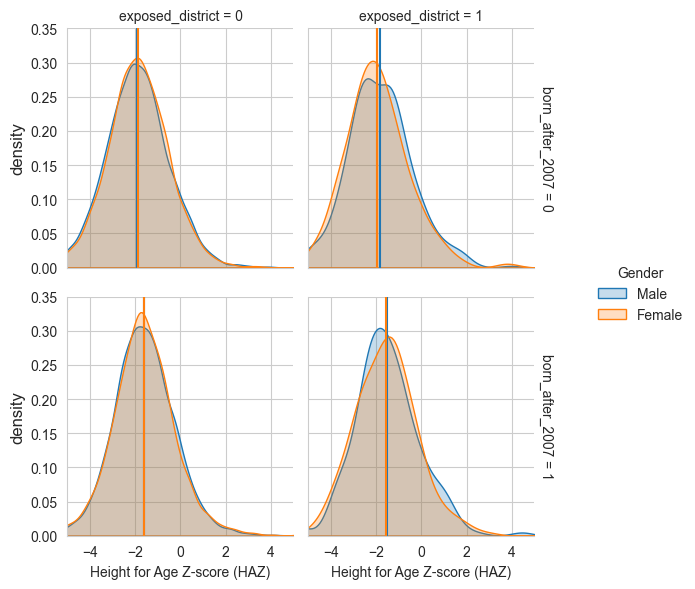

In [ ]:
df_shp.columns = [n if n != "KIDSEX" else "Gender" for n in df_shp.columns]
df_shp.columns = [n if n != "exposed_distr_1" else "exposed_district" for n in df_shp.columns]
df_shp.columns = [n if n != "born_after" else "born_after_2007" for n in df_shp.columns]

g = sns.FacetGrid(df_shp, col="exposed_district", row="born_after_2007", hue="Gender", margin_titles=True,ylim=(0, 0.35), xlim=(-5, 5),sharex=True, sharey=True)
g.map(sns.kdeplot, "HWHAZWHO",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'HWHAZWHO')
#g5 = sns.displot(data=df, col='YEAR', hue='KIDSEX', x='HWWAZWHO', kind='kde', col_wrap=3,fill=True, facet_kws={'sharey': False, 'sharex': False})

# Add text to each plot for relevant popultion size
# NOTE - don't need to filter on ['Age'].isnull() for children, as 'is_child'=True only possible for children with 'Age' data
# for row in range(grid.axes.shape[0]):
#     grid.axes[row, 0].text(60.2, 0.052, 'Survived n = '+str(titanic_data.loc[titanic_data['Pclass']==row+1].loc[titanic_data['is_child_def']==False].loc[titanic_data['Age'].isnull()==False].loc[titanic_data['Survived']==1]['is_male'].sum()), size = 12)
#     grid.axes[row, 1].text(60.2, 0.052, 'Survived n = '+str(titanic_data.loc[titanic_data['Pclass']==row+1].loc[titanic_data['is_child_def']==False].loc[titanic_data['Age'].isnull()==False].loc[titanic_data['Survived']==1]['is_female'].sum()), size = 12)
#     grid.axes[row, 0].text(60.2, 0.047, 'Perished n = '+str(titanic_data.loc[titanic_data['Pclass']==row+1].loc[titanic_data['is_child_def']==False].loc[titanic_data['Age'].isnull()==False].loc[titanic_data['Survived']==0]['is_male'].sum()), size = 12)
#     grid.axes[row, 1].text(60.2, 0.047, 'Perished n = '+str(titanic_data.loc[titanic_data['Pclass']==row+1].loc[titanic_data['is_child_def']==False].loc[titanic_data['Age'].isnull()==False].loc[titanic_data['Survived']==0]['is_female'].sum()), size = 12)
#ax.set(xlabel='Height for Age Z-score (HAZ)', ylabel='common ylabel')
g.set_axis_labels("Height for Age Z-score (HAZ)")
g.set_ylabels('density', size=12)
#plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
#filename = 'Weight for Age Z-score density'
#plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)
filename="by_gender_distribution_haz_norm"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

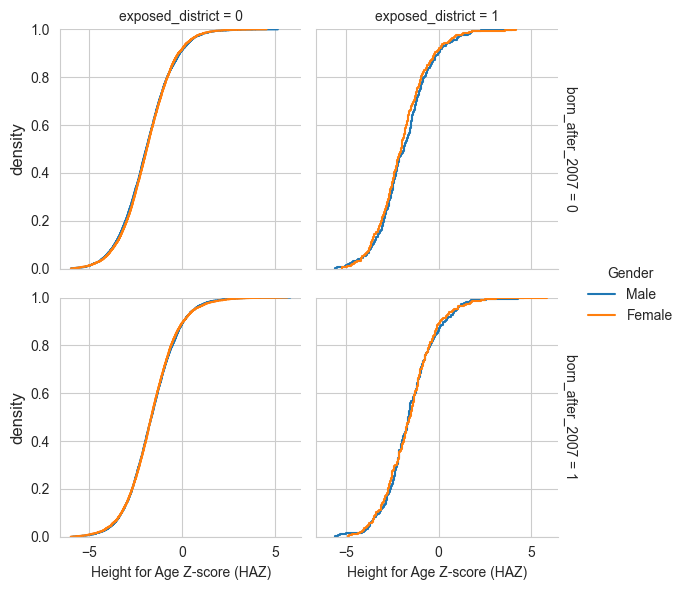

In [ ]:
#cumulative

g = sns.FacetGrid(df_shp, col="exposed_district", row="born_after_2007", hue="Gender", margin_titles=True,sharex=True, sharey=True)
g.map(sns.ecdfplot, "HWHAZWHO",   stat='proportion')
g.add_legend()

#g.map(vertical_mean_line_survived, 'HWHAZWHO')

g.set_axis_labels("Height for Age Z-score (HAZ)")
g.set_ylabels('density', size=12)

filename="by_gender_distribution_haz_cum"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

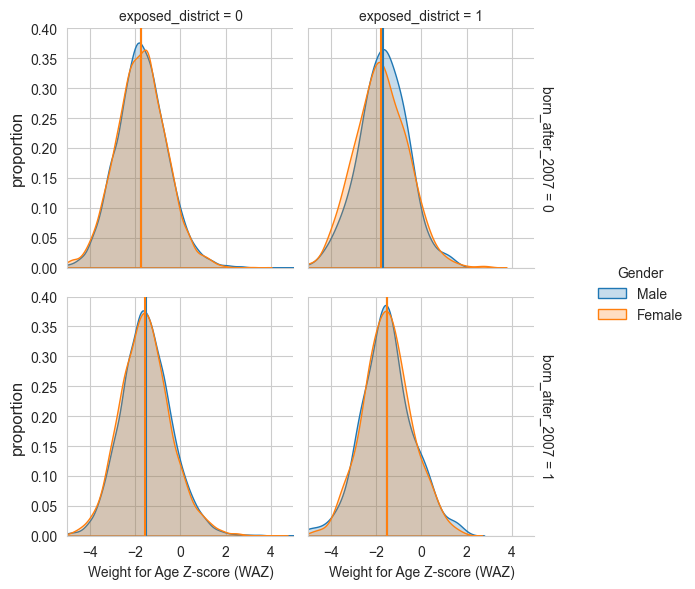

In [ ]:
# df_interest.columns = [n if n != "KIDSEX" else "Gender" for n in df_interest.columns]
# df_interest.columns = [n if n != "exposed_distr_1" else "exposed_district" for n in df_interest.columns]
# df_interest.columns = [n if n != "born_after" else "born_after_2007" for n in df_interest.columns]

g = sns.FacetGrid(df_shp, col="exposed_district", row="born_after_2007", hue="Gender", margin_titles=True,ylim=(0, 0.4), xlim=(-5, 5),sharex=True, sharey=True)
g.map(sns.kdeplot, "HWWAZWHO",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'HWWAZWHO')

g.set_axis_labels("Weight for Age Z-score (WAZ)")
g.set_ylabels('proportion', size=12)

#g.axes[0,1].set_xlabel('axes label 1')

filename="by_gender_distribution_waz_interested"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

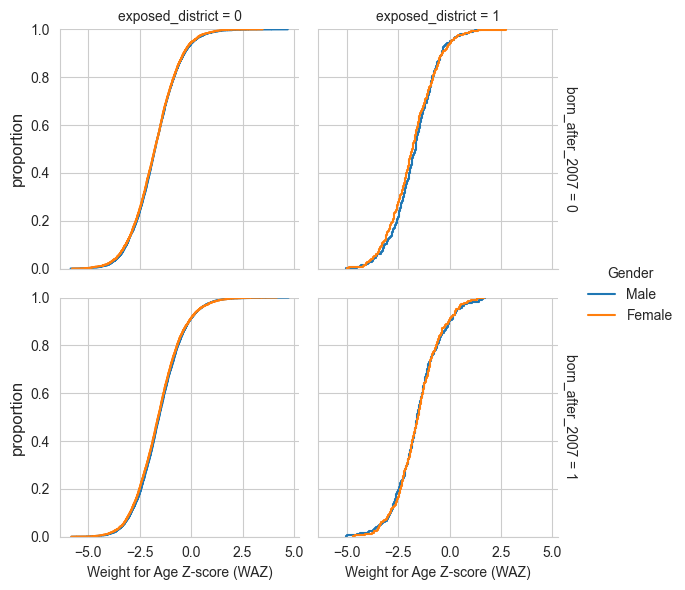

In [ ]:
#cumulative

g = sns.FacetGrid(df_shp, col="exposed_district", row="born_after_2007", hue="Gender", margin_titles=True,sharex=True, sharey=True)
g.map(sns.ecdfplot, "HWWAZWHO",   stat='proportion')
g.add_legend()

#g.map(vertical_mean_line_survived, 'HWHAZWHO')

g.set_axis_labels("Weight for Age Z-score (WAZ)")
g.set_ylabels('proportion', size=12)

filename="by_gender_distribution_waz_cum"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

AttributeError: Line2D.set() got an unexpected keyword argument 'scheme'

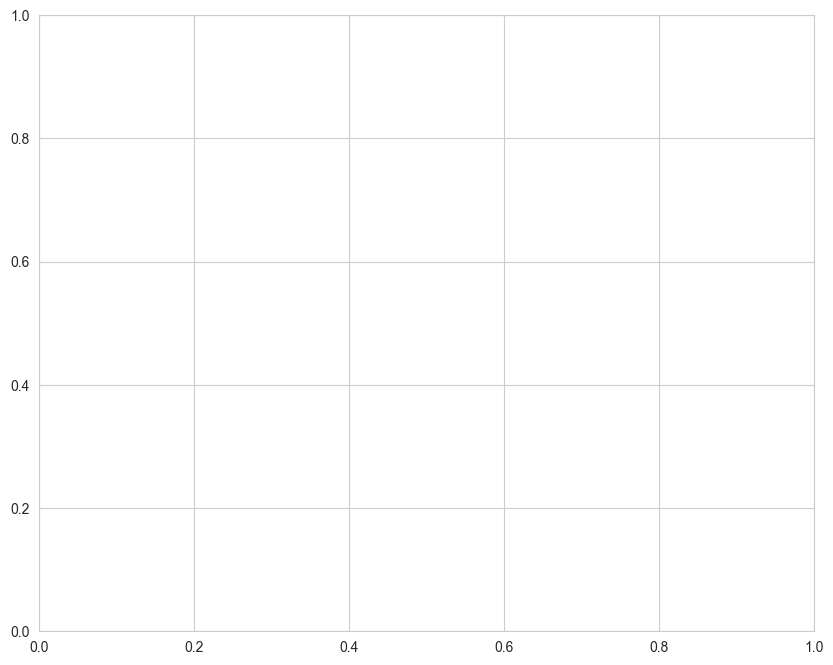

In [ ]:

# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(1, figsize=(10,8))
cmap = 'Greys'
df_interest.plot(column="HWWAZWHO", scheme="quantiles", k=8, cmap=cmap, ax = ax, edgecolor='0.8', legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": False})
ax.axis('off')
ax.set_title('Fully Damaged Households', fontdict={'fontsize': '15'})
# Create an annotation for the data source
ax.annotate('Source: London Datastore, 2014',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='#555555')


<Axes: xlabel='DHSID,geometry'>

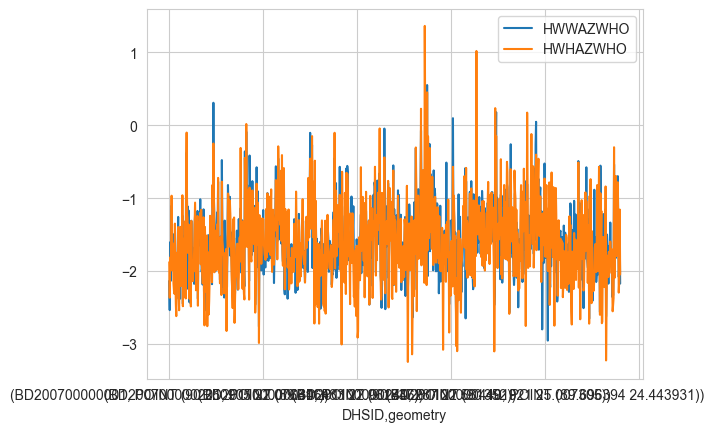

In [ ]:
df_interest.groupby(['DHSID','geometry'])[['HWWAZWHO', 'HWHAZWHO']].mean().plot(column="HWWAZWHO")

In [ ]:
df_interest = gpd.GeoDataFrame(df, geometry='geometry')

ValueError: Unknown column geometry

In [ ]:
df_interest.columns

Index(['SAMPLE', 'SAMPLESTR', 'COUNTRY', 'YEAR', 'IDHSPID', 'IDHSHID', 'DHSID',
       'IDHSPSU', 'IDHSSTRATA', 'CASEID', 'HHID', 'PSU', 'STRATA', 'DOMAIN',
       'HHNUM', 'CLUSTERNO', 'LINENO', 'BIDX', 'PERWEIGHT', 'KIDWT', 'AWFACTT',
       'AWFACTU', 'AWFACTR', 'AWFACTE', 'AWFACTW', 'DVWEIGHT', 'URBAN',
       'GEO_BD1994_2014', 'GEO_BD1997', 'GEO_BD2000', 'GEO_BD2004',
       'GEO_BD2007', 'GEO_BD2011', 'GEO_BD2014', 'AGE', 'AGE5YEAR', 'RESIDENT',
       'RELIGION', 'MARSTAT', 'CHEB', 'CURRWORK', 'WEALTHQ', 'WEALTHS',
       'EDUCLVL', 'EDYRTOTAL', 'Gender', 'LINENOKID', 'KIDAGEMO', 'HWWEIGHT',
       'HWHEIGHT', 'HWWHYNOTMEAS', 'HWDAYOFBIRTH', 'HWHAZWHO', 'HWWAZWHO',
       'HWWHZWHO', 'HWBMIZWHO', 'born_after_2007', 'Unnamed: 0', 'DHSCC',
       'DHSYEAR', 'DHSCLUST', 'CCFIPS', 'ADM1FIPS', 'ADM1FIPSNA', 'ADM1SALBNA',
       'ADM1SALBCO', 'ADM1DHS', 'ADM1NAME', 'DHSREGCO', 'DHSREGNA', 'SOURCE',
       'URBAN_RURA', 'LATNUM', 'LONGNUM', 'ALT_GPS', 'ALT_DEM', 'DATUM',
       'geome

In [ ]:
pd.crosstab(df_shp.born_after, [df_shp.exposed_distr_1, df_shp.KIDSEX], values=df_shp.HWWAZWHO, aggfunc='mean')

#### Using data for Ministry of Food and Disaster Management